<br>

# League of Legends Data Project
___

## Part II: Analytics & Predictive Modeling
___
In Part I of this project, we accessed the Riot Games API and learned how to compile League of Legends match history information into a database ready for analytics, and stored that data in a permanent local copy.

The data gathered in Part I can be customized to the user's personal interest by specifying a new Summoner Name and match type(s) and re-executing the API calls. However, the original data has been included for your use as well.

In this section, the aim becomes to explore the data—look for trends, patterns, and connections—and then apply a collection of predictive modeling functions to connect those patterns with our defined target: whether the match resulted in a Win or a Loss for the player.

### Table of Contents
___
1. [**Data Loading & Preprocessing**](#dlp)<br>
    *Reading in Match Data and preparing to run predictions*
    + [Preprocessing—standard](#preprocessing)
    + [Preprocessing—specialized](#special-prep)
        - *Summary statistics*
    + [Data Preparation](#prep) 
        - *Train-Test Split, Normalization* 
<br>
<br>
2. [**Exploratory Data Analysis**](#eda)<br>
    *Visualizing Target Distribution and other features*
<br>
<br>
3. [**Modeling & Prediction**](#models)
    + [Decision Tree](#decision-tree)
    + [Extremely Random ("Extra") Trees](#extra-trees)
    + [Random Forest](#random-forest)
        - [*Feature Importance*](#feature-importance) *in decision trees*
        - [*Collective Intelligence*](#collective-intelligence), *how groups become smarter*
    + [Boosting](#boosting)
    + [Gradient Boosting](#gradient-boosting)
    + [Bagging](#bagging)
    + [Logistic Regression](#logistic-regression)
    + [Naïve Bayes](#bayes)
    + [*k*-Nearest Neighbors (KNN)](#knn)
    + [Stacking (Ensemble Voting)](#stacking)
    + [Support Vector Machines (SVM)](#svm)
    + [Artificual Neural Network (ANN)](#ann)
<br>
<br>
4. [**Results & Conclusion**](#results)<br>
    *Summary table of Model Scores. Final recommendation. Looking forward.*
<br>
___

### Setup
___
> **Note:** *Running (reproducing) the code in this notebook will require the [PyTimeParse](https://github.com/wroberts/pytimeparse) package (for converting match durations to seconds).*
>
> *Install it through Anaconda Navigator's Environments command prompt:* `pip install pytimeparse`

In [1]:
# Import packages

%matplotlib inline 
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import time
import datetime
import itertools
import pytimeparse
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

In [2]:
# Suppress deprecation warning messages
import warnings
warnings.filterwarnings("ignore")

In [3]:
print("This project was created in Python version %s.%s.%s" % sys.version_info[:3])

This project was created in Python version 3.6.4


In [4]:
# Get current working directory
os.getcwd()

In [5]:
# Change directory
os.chdir('')

(Credit for official display [fonts](https://github.com/tracyfu/lol-armory/tree/master/app/assets/fonts), and the [code](https://stackoverflow.com/questions/33061785/can-i-load-google-fonts-with-matplotlib-and-jupyter) for implementing them in plots.)

In [6]:
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

github_url = 'https://github.com/tracyfu/lol-armory/blob/master/app/assets/fonts/Beaufort-Bold.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

response = urlopen(url)
f = NamedTemporaryFile(delete = False, suffix = '.ttf')
f.write(response.read())
f.close()

main = fm.FontProperties(fname = f.name)

github_url = 'https://github.com/tracyfu/lol-armory/blob/master/app/assets/fonts/Spiegel-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

response = urlopen(url)
g = NamedTemporaryFile(delete = False, suffix = '.ttf')
g.write(response.read())
g.close()

body = fm.FontProperties(fname = g.name)

<br>

### Data Loading & Preprocessing
___
The data (created in Part I of this project) represents a League of Legends match history for player "Proxy Fox" (the author's personal account), with 1100 observations on 176 features. All matches are of the ARAM game mode.

**Prediction Goal: Predict Match Outcome (Win/Loss) based on available attributes and statistics.**

An overview of the features, by [column or range] is included below.

 * [0]: **Match ID#** (int)— unique 10-digit identifier for the match
 * [1]: **Duration** (timecode) — length of the match in HH:MM:SS
 * [2]: **Side** (factor, 2 levels)['Red', 'Blue'] — player team's side of the map
 * [3]: **Win** (boolean) — the intended Target: "True" if player's team won the match
 * [4]: **First Blood** (boolean) — "True" if player's team made the first enemy kill
 * [5]: **First Tower** (boolean) — "True" if player's team destroyed the first tower
 * [6]: **Champion** (factor, 114 levels) — name of the player's Champion
 * [7]: **Champion Type** (factor, 6 levels) — type of the player's Champion
 * [8]: **Mastery Level** (int) — player's lifetime Mastery score for that Champion
 * [9]: **Level** (int) — player's level attained in the match (max 18)
 * [9:35]: **Player Stats** (int) — various post-game stats for the player, like Kills, Deaths, Damage Dealt, and Healing Done.
 * [36:176]: **Teammates** (binary) — a sparse matrix of all 140 Champions, indicating which four others composed the player's team.

The data was generated over a period of approximately two years. It was accessed via the [Riot Games API](https://developer.riotgames.com/) and imported with the third-party [Cassiopeia](https://zenodo.org/record/1183285#.WukZMIgvyUk) API framework for Python.

> ##### A Background for non-Leaguers
> ___
> League of Legends is a Massively Online Battle Arena (MOBA) published by Riot Games. It is free-to-play on PC.
>
> The game's "Champions", currently numbering 140, are unique avatars that players ("Summoners") control in a match. Each has a unique skillset and special strengths—and weaknesses—and falls roughly within one of a few broad categories, like Damage, Tank, or Support.
>
> League's premier game mode, *Summoner's Rift*, pits two teams of five players against each other to capture objectives and destroy the enemy base. This mode is typically referred to simply as "Normal". A Ranked version also exists, which is the subject of officially-sponsored "e-sports" competitions, where professional teams from all over the world compete for cash prizes. 
>
> ARAM ("All Random All Mid") is a more straightforward and dynamic variant of this game mode. 
>
> Key distinctions include random assignment of Champions—*"All Random"* (in Normal matches, players can pick their favorite), and a single lane that forces more direct team battles—*"All Mid"* (the Normal map has three lanes, requiring teammates to strategize and communicate more effectively.)
> ___
> Understanding the "business question" is an essential part of data science. Look for ***"League explained"*** comments throughout the notebook for deeper insight as to how certain aspects of the data help to answer our question.

In [7]:
# Read in the saved CSV file
df = pd.read_csv('data/proxy_fox_aram_1100.csv')

df.shape

(1100, 176)

> The code in this notebook is designed to be standardized—easily copied and reused from one project to another. 
>
> Thus, we use generic names (`df` for the dataframe, `target` for the variable we're trying to predict, etc.) whenever possible.

In [8]:
# Preview
df.head()

,match_id,duration,side,win,team_first_blood,team_first_tower,champion,champion_type,mastery_level,level,...,tmate_Xerath,tmate_Xin_Zhao,tmate_Yasuo,tmate_Yorick,tmate_Zac,tmate_Zed,tmate_Ziggs,tmate_Zilean,tmate_Zoe,tmate_Zyra
0,2775186012,0 days 00:18:12.000000000,blue,False,True,False,Xayah,Marksman,2,16,...,0,0,0,0,0,1,0,0,0,0
1,2775165096,0 days 00:18:38.000000000,red,True,True,True,Rakan,Support,4,17,...,0,0,0,0,0,0,0,0,0,0
2,2774959782,0 days 00:22:05.000000000,red,True,True,False,Zyra,Mage,2,18,...,0,0,0,0,0,0,0,0,0,0
3,2774936273,0 days 00:18:25.000000000,red,True,False,True,Maokai,Tank,3,17,...,0,0,0,0,0,0,0,0,0,0
4,2774941224,0 days 00:19:21.000000000,blue,False,False,False,Rakan,Support,4,16,...,0,0,0,0,0,0,0,0,0,0


> The format of `duration` is unsuitable for analysis. We'll need to convert it from a timecode into a pure numeric value (seconds).

In [9]:
# Convert match durations to seconds
from pytimeparse.timeparse import timeparse
df['duration'] = df['duration'].apply(lambda t: timeparse(t))

In [10]:
df[['duration']].head()

,duration
0,1092.0
1,1118.0
2,1325.0
3,1105.0
4,1161.0


<br>

##### Preprocessing

A number of functions can be used to automatically transform our data for easy use with model-creating code later on, meaning that any changes to the underlying data can be accounted for without having to re-work every line of code.

We'll assign the target variable, `win`, a generic name—`targetName`—and move it to the first column (Column 0) in the dataframe.

In [11]:
# Move target variable to the front
targetName = 'win'

targetSeries = df[targetName]
del df[targetName]
df.insert(0, targetName, targetSeries)
expected = targetName

For the purpose of running models, we need to exclude any variables that are clearly not associated with prediction. 

Here, that is `match_id`.

In [12]:
# Drop non-predictive data
df = df.drop(columns = ['match_id'])

This "prefab" code can be applied to any data, as long as it uses the generic name `df`, and the target was processed as above. It will binarize (convert to binary) any object-type variables, creating a column for each unique value—so that `champion == 'Teemo'` would become `champion_Teemo == 1`.

In [13]:
# Create dummies of any categorical features
for col in df.columns[1:]:
	attName = col
	dType = df[col].dtype
	missing = pd.isnull(df[col]).any()
	uniqueCount = len(df[attName].value_counts(normalize = False))
	# Create dummies
	if dType == object:
		df = pd.concat([df, pd.get_dummies(df[col], prefix = col)], axis = 1)
		del df[attName]

In [14]:
# Get the updated shape
df.shape

(1100, 294)

> Binarizing string objects (like Champion name and Side) increased our feature (column) count from 176 to 294.
> 
> We may want to try some feature selection methods later on, to reduce the number of variables going into the models. However, it isn't a critical concern as long as we have more observations (1100) than variables.

 Next, most models prefer numbers over boolean values, so we use a simple label encoder to change any values of (True, False) to (1, 0).

In [15]:
# Encode boolean values as binary
le_dep = preprocessing.LabelEncoder()

for col in df.columns[:]:
    attName = col
    dType = df[col].dtype
    if dType == bool:
        df[col] = le_dep.fit_transform(df[col])

In [16]:
# Encoding labels manually
#df[targetName] = le_dep.fit_transform(df[targetName])

#df['team_first_blood'] = le_dep.fit_transform(df['team_first_blood'])
#df['team_first_tower'] = le_dep.fit_transform(df['team_first_tower'])

In [17]:
# Preview some of the binarized features
df.iloc[0:5, [0, 2, 3, 290, 291, 292, 293]]

,win,team_first_blood,team_first_tower,champion_type_Mage,champion_type_Marksman,champion_type_Support,champion_type_Tank
0,0,1,0,0,1,0,0
1,1,1,1,0,0,1,0
2,1,1,0,1,0,0,0
3,1,0,1,0,0,0,1
4,0,0,0,0,0,1,0


Now we need to check for missing values. It's unlikely that we find any, because League collects its own data, but it's always good practice to run this check. Some models will even refuse to run if any values are missing.

In [18]:
# Check for NAs
df.isnull().sum().sum()

# NAs by column
#df.isnull().sum()

0

> No missing values in the data!

If any numeric features were missing data, the following code would fill the blanks with that column's median value.

In [19]:
# Impute null values with the column median
#df = df.groupby(df.columns, axis = 1).transform(lambda x: x.fillna(x.median()))

# Verify that 0 nulls remain
#d2.isnull().sum().sum()

> A more extreme method for handling large amounts of missing data would be to use the `dropna` command to drop entire rows and/or columns which contain any NA values.

<br>

##### Specialized preprocessing

Next, we can load the summary statistics file (created in Part I of this project) and manually check if any further processing is needed.

In [20]:
# Load the summary statistics file
summary = pd.read_csv('data/proxy_fox_aram_1100_summary.csv', index_col = 0)

# This is the code used to generate summary statistics from the ORIGINAL dataframe 
# (before any of the transformations in this notebook were made)
#summary = df.iloc[:, 1:36].describe()

summary.shape

(8, 29)

> The summary table contains 8 features (summary stats) of 29 observations (the continuous-numeric variables from the full dataset). Currently, this is laid out as 8 rows and 29 columns. We can `transpose` the table into "long form" to make reading more intuitive.

In [21]:
summary['duration'] = summary['duration'].str.replace('days', '')

In [22]:
# Transpose rows and columns
summary = summary.transpose()

In [23]:
# Preview the table
summary.head(6)

,count,mean,std,min,25%,50%,75%,max
duration,1100,0 00:20:28.785454,0 00:04:59.179149,0 00:09:38,0 00:16:42,0 00:19:48.500000,0 00:23:22,0 00:39:53
mastery_level,1100,3.37091,1.35865,1,2,4,5,5
level,1100,16.3182,1.92693,9,15,17,18,18
kills,1100,5.84364,4.66231,0,2,5,8,31
deaths,1100,7.71636,3.70494,0,5,8,10,22
assists,1100,23.5673,10.5727,2,16,23,30,77


We can select a subset of the table to view, by specifying both the rows (stats) and columns (statistical measures).

Below, we specify a range of stats in rows `6:29`, and select only the minimum, maximum, and average measurements—in columns `[3, 1, 7]` respectively.

In [24]:
summary.iloc[6:29, [3, 1, 7]]

,min,mean,max
total_damage_dealt_to_champions,1647,20210.8,115882
physical_damage_dealt_to_champions,0,5107.35,62848
magic_damage_dealt_to_champions,0,14248.8,112339
true_damage_dealt_to_champions,0,853.943,20183
total_damage_dealt,6625,61224.2,318407
physical_damage_dealt,282,18070,171517
magic_damage_dealt,0,40810.2,313161
true_damage_dealt,0,2343.39,54756
largest_critical_strike,0,142.928,1554
largest_killing_spree,0,1.98818,11


> There's one little quirk in these stats. Can you spot it?

In [25]:
summary.iloc[25:29, [3, 1, 7, 2]]

,min,mean,max,std
total_minions_killed,3,43.3155,180,27.2944
gold_earned,5805,12004.3,25517,2975.06
total_time_crowd_control_dealt,0,373.695,8738,772.592
longest_time_spent_living,0,298.556,1202,142.568


> `longest_time_spent_living` has a minimum value of 0. <br>
> Since it's impossible to spend an entire match dead, something else must be going on.
>
> I recently played a match as Vel'Koz where I never died *(humble brag)*, so I'm curious to see how that's recorded by `longest_time_spent_living`.

In [26]:
# Display select data for all Vel'Koz games
df[df["champion_Vel\'Koz"] == 1].iloc[:, [1, 31]]

,duration,longest_time_spent_living
21,865.0,0
86,2172.0,300
164,1096.0,185
226,1131.0,379
229,772.0,707
1051,1291.0,206


> There it is, right at the top.
>
> We can fix this by setting `longest_time_spent_living` equal to `duration` when the former is zero.

In [27]:
zeroes = df['longest_time_spent_living'] == 0
df.loc[zeroes, 'longest_time_spent_living'] = df['duration']

In [28]:
# Verify the fix
df[df["champion_Vel\'Koz"] == 1].iloc[:, [1, 31]]

,duration,longest_time_spent_living
21,865.0,865.0
86,2172.0,300.0
164,1096.0,185.0
226,1131.0,379.0
229,772.0,707.0
1051,1291.0,206.0


<br>

##### Preparing for analysis

Now that the data has been thoroughly preprocessed, there are a few final steps to take in formatting the data for use with predictive models.
* Split the dataframe 70/30 into Training and Test sets.
* Perform separate scaling (0-1) and standardization (z-score) functions on the data.

In [29]:
# Split dataset into Training and Test sets
features_train, features_test, target_train, target_test = train_test_split(
    df.iloc[:,1:].values, df.iloc[:,0].values,
    test_size = 0.30,
    random_state = 7)

In [30]:
# Confirm sizes of Train and Test sets
print("Train data:", features_train.shape)
print("Test data:", features_test.shape)
print("Train target:", target_train.shape)
print("Test target:", target_test.shape)
print("")
print("Percent of Wins in Test Data:", "{0:.3f}%".format(target_test.mean()*100))
print("Base Accuracy Rate:", "{0:.3f}%".format((1-target_test.mean())*100))

# Set the base accuracy rate, used to evaluate model performance
base = 1-target_test.mean()

Train data: (770, 293)
Test data: (330, 293)
Train target: (770,)
Test target: (330,)

Percent of Wins in Test Data: 49.394%
Base Accuracy Rate: 50.606%


> The **Base Accuracy Rate** (BAR) is important in properly evaluating models. When the target distribution is unequal (e.g. more 0s than 1s), the BAR is the proportion of *random, uninformed guesses* that should be correct. Thus, models are evaluated based upon their additional accuracy above the BAR.

In [31]:
# Scale data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Don't cheat - fit only on training data
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)  

In [32]:
# Standardize data by z-score
from sklearn.preprocessing import StandardScaler

z_scale = StandardScaler()

# Normalize ONLY the columns that have continuous values. Ignore binary variables.
# The columns we want are [0] and [3:31]

# Excuse the ugly code, it was the only way I could find that worked
# Basically, split the features into subsets (the ones you want to normalize) and binaries (the ones you don't)
# Then mash them all back together into a single Frankenstein of an array
features_train_z_subset1 = z_scale.fit_transform(features_train[:, 0:1])
features_train_z_binaries1 = features_train[:, 1:3]
features_train_z_subset2 = z_scale.fit_transform(features_train[:, 3:31])
features_train_z_binaries2 = features_train[:, 31: ]

features_train_z = np.concatenate((features_train_z_subset1, 
                                   features_train_z_binaries1, 
                                   features_train_z_subset2, 
                                   features_train_z_binaries2),
                                  axis = 1)

In [33]:
# Make sure it matches the original features_train.shape
features_train_z.shape

(770, 293)

In [34]:
# Frankencode for the Test set

features_test_z_subset1 = z_scale.fit_transform(features_test[:, 0:1])
features_test_z_binaries1 = features_test[:, 1:3]
features_test_z_subset2 = z_scale.transform(features_test[:, 3:31])
features_test_z_binaries2 = features_test[:, 31: ]

features_test_z = np.concatenate((features_test_z_subset1, 
                                  features_test_z_binaries1, 
                                  features_test_z_subset2, 
                                  features_test_z_binaries2),
                                 axis = 1)

In [35]:
# Make sure it matches the original features_test.shape
features_test_z.shape

(330, 293)

> ##### Scaling vs. Standardizing
> ___
> When building models, we now have access to three varieties of the data:
> * **Min-max Scaled**—all values are fit into the range of (0, 1).
> * **z Standardized**—numeric values are expressed in z-scores, or standard deviations from a mean of zero.
> * **Unprocessed**—values are left as-is.
>
> Each has its advantages, namely in specific models or situations. **Standardization** improves performance on distance-based models, like Logistic Regression with L2 or L1 normalization. However, it assumes that the values of a feature are normally distributed. We will need to verify that in EDA to determine if this is a good choice. <br>
**Min-max Scaling** is better suited for data that isn't normally distributed, and is useful in machine learning applications like SVM and Neural Networks. It is also useful to retain the **unprocessed** data. Decision tree-based classifiers tend not to be affected by a lack of normalization—and it can be useful to display true values if you plan to actually visualize a Decision Tree.
> ___
> [Source](https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/)

<br>

### Exploratory Data Analysis
___
In this section, we will focus on the distributions and relationships in our dataset. <br>
Visualization will be the primary medium for exploring and understanding the data.

##### Target variable distribution

Target distribution is one of the most important aspects of a dataset to understand before running models. Unbalanced target values (for example, a dataset with 10% Positive and 90% Negative values) can massively affect how we run and evaluate models.

A simple countplot can show the balance of Wins and Losses (the target levels).

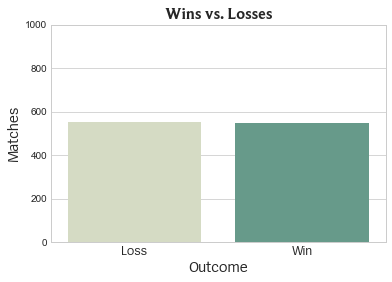

win
0    551
1    549
dtype: int64

In [36]:
# Plot the target variable distribution
sns.set_style("whitegrid")
cols = sns.palettes.cubehelix_palette(2, dark = 0.55, start = 0.5, rot = -0.75)

sns.countplot(x = df[targetName], data = df, palette = cols)
plt.title('Wins vs. Losses', fontproperties = main, fontsize = 16)
plt.ylabel('Matches', fontproperties = body, fontsize = 15)
plt.xlabel('Outcome', fontproperties = body, fontsize = 15)
plt.xticks([0, 1], ['Loss', 'Win'], fontproperties = body, fontsize = 13)
plt.ylim(0, 1000)
plt.show()

# Display counts of target
targetdist = df.groupby(targetName).size()

targetdist

> The results?
>
> I am a *remarkably* adequate ARAM player. The target distribution is an almost perfect 50/50 split between Wins and Losses.

##### Distributions of continuous values

Next, we can plot histograms of several variables to verify that their values are approximately normally distributed (bell-curve-shaped).

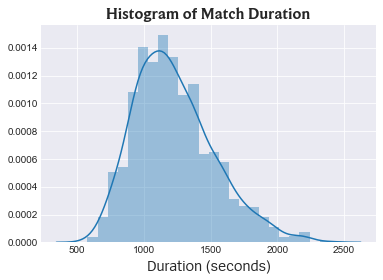

In [37]:
# Plot match duration
sns.set_style("darkgrid")
sns.distplot(df['duration'], kde = True, rug = False)
plt.title('Histogram of Match Duration', fontproperties = main, fontsize = 16)
plt.xlabel('Duration (seconds)', fontproperties = body, fontsize = 15)
plt.show()

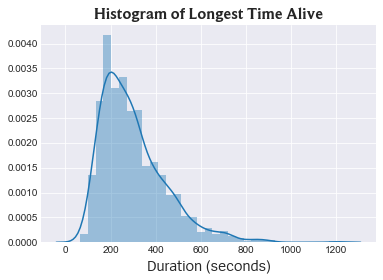

In [38]:
# Plot longest time alive
sns.distplot(df['longest_time_spent_living'], kde = True, rug = False)
plt.title('Histogram of Longest Time Alive', fontproperties = main, fontsize = 16)
plt.xlabel('Duration (seconds)', fontproperties = body, fontsize = 15)
plt.show()

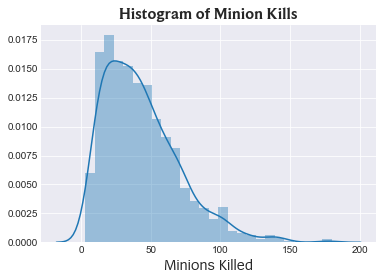

In [39]:
# Plot minion kills
sns.distplot(df['total_minions_killed'], kde = True, rug = False)
plt.title('Histogram of Minion Kills', fontproperties = main, fontsize = 16)
plt.xlabel('Minions Killed', fontproperties = body, fontsize = 15)
plt.show()

> Most of the features appear to be negatively skewed (left-leaning) to some degree. This could negatively impact the results of using the z-Standardized data we created above, but should not have other significant effects.

##### Autocorrelation (two-variable interactions)

Next, we can examine some interactions between variables. <br>
Two variables are said to be *autocorrelated* when they change predictably in relation to one another. <br>
(e.g. if `magic_damage_dealt` increases, it is also highly likely that `total_damage_dealt` will increase by a similar proportion.)

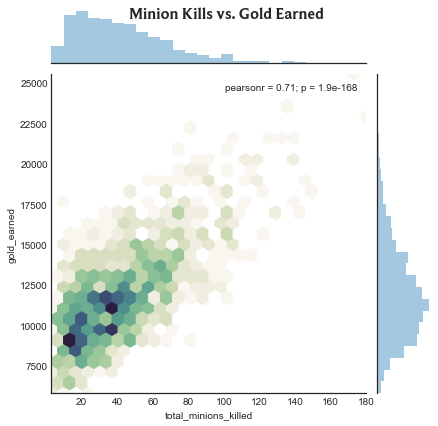

In [40]:
# Plot minion kills vs. gold earned
cmap = sns.cubehelix_palette(light = 1, start = 0.5, rot = -0.75, as_cmap = True)

with sns.axes_style("white"):
    p = sns.jointplot(x = df['total_minions_killed'], 
                      y = df['gold_earned'], 
                      kind = 'hex', 
                      cmap = cmap);

p.fig.suptitle('Minion Kills vs. Gold Earned', fontproperties = main, fontsize = 16)
plt.show()

> The correlation coefficient is 0.71. That is, `total_minions_killed` explains 71% of the variance in `gold_earned`.

> ***League explained:*** *Minions and Gold*
> ___
> *Minions* are computer-controlled allies and enemies which spawn in regular waves throughout the match to aid their respective team. <br> Defeating enemy minions is the primary activity for earning *Gold*, which players can use to purchase stat-enhancing items during that match. <br> 
> Other sources of Gold include defeating enemy Champions, completing team objectives, and passive earning throughout the duration of the match.

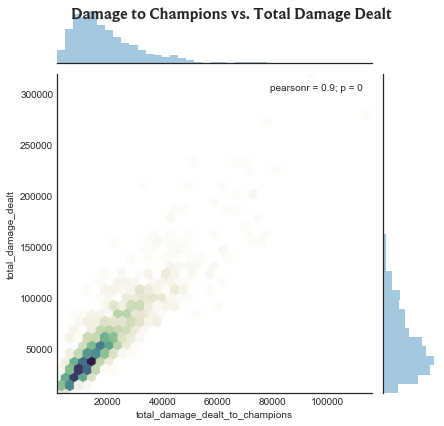

In [41]:
# Damage to champions vs. total damage
cmap = sns.cubehelix_palette(light = 1, start = 0.5, rot = -0.75, as_cmap = True)

with sns.axes_style("white"):
    p = sns.jointplot(x = df['total_damage_dealt_to_champions'], 
                      y = df['total_damage_dealt'], 
                      kind = 'hex', 
                      cmap = cmap);

p.fig.suptitle('Damage to Champions vs. Total Damage Dealt', fontproperties = main, fontsize = 16)
plt.show()

> Some of the variables in the data are very strongly (but not perfectly) correlated with one another. `total_damage_dealt_to_champions` is 90% correlated to `total_damage_dealt` (which is the sum of `total_damage_dealt_to_champions`, `damage_dealt_to_objectives`, and damage to Minions).

More on the "just for fun" or "satisfying curiosity" side, let's pull up the original data again so we can visualize some of the categorical variables—like Champion Type and Side.

In [42]:
df_orig = pd.read_csv('data/proxy_fox_aram_1100.csv')

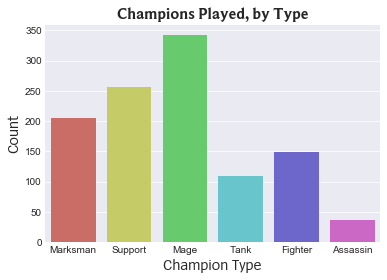

In [43]:
# Plot counts of champions by type
sns.set_style("darkgrid")
sns.countplot(x = df_orig['champion_type'], data = df, palette = 'hls')
plt.title('Champions Played, by Type', fontproperties = main, fontsize = 16)
plt.ylabel('Count', fontproperties = body, fontsize = 15)
plt.xlabel('Champion Type', fontproperties = body, fontsize = 15)
plt.show()

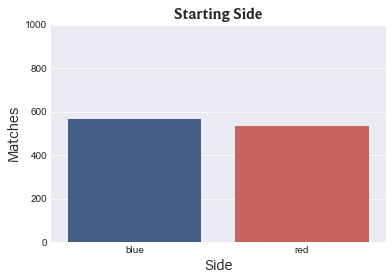

In [44]:
# Plot red side vs. blue side
rb = [sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["pale red"]]
sns.countplot(x = df_orig['side'], data = df, palette = rb)
plt.title('Starting Side', fontproperties = main, fontsize = 16)
plt.ylabel('Matches', fontproperties = body, fontsize = 15)
plt.xlabel('Side', fontproperties = body, fontsize = 15)
plt.ylim(0, 1000)
plt.show()

> There are slightly more Blue Side matches than Red Side matches.

> ***League explained:*** *Why is Red vs. Blue side important?*
> ___
> When a match is created, each team is randomly assigned to play on the Blue or Red side. This affects their starting position and direction of play. Blue team's base is at the bottom-left corner of the map, so they play from left to right. Red team, conversely, begins in the top-right corner, and must push right-to-left.
>
> Some have argued—and a few [studies have supported](https://kotaku.com/yes-the-blue-team-has-an-advantage-in-league-of-legend-1578533860)—that Blue side has an inherent advantage due to its more natural left-to-right progression across the map. This format is, after all, how new players are introduced to the game. In matches where a team of human players competes against computer-controlled enemy Champions, the human team is always on Blue side.
>
> Now, we can test the "Blue Team Advantage" theory against our own data.

In [45]:
# Crosstab of win rate by side
xtab = pd.crosstab(df_orig['side'], df_orig['win'],
                   rownames = ['Side'], colnames = ['Win'], 
                   normalize = 'index')

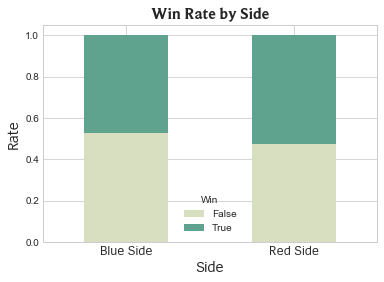

Win,False,True
Side,,
blue,0.527434,0.472566
red,0.472897,0.527103


In [46]:
# Graph win rate
sns.set_style("whitegrid")
cols = sns.palettes.cubehelix_palette(2, dark = 0.55, start = 0.5, rot = -0.75)

xtab.plot(kind = 'bar', stacked = True, color = cols)

plt.title('Win Rate by Side', fontproperties = main, fontsize = 16)
plt.ylabel('Rate', fontproperties = body, fontsize = 15)
plt.xlabel('Side', fontproperties = body, fontsize = 15)
plt.xticks([0, 1], ['Blue Side', 'Red Side'], rotation = 0, fontproperties = body, fontsize = 13)
plt.show()

xtab

> Contrary to the popular theory, the data shows that I actually have an advantage on **Red** team. My win rate when playing on the Red side was 52.7%, compared to a win rate of 47.3% when playing Blue.

<br>

### Modeling & Prediction
___
Several predictive model classes and variations will be evaluated on our data. Their performance will be summarized at the beginning of each respective model section, in a table like the example below.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|      **Lift**       |   **CV Spread**   |
|-------------|---------------|---------------------|-------------------|
|     CLF 1   |     xx.xx%    |       +xx.xx%       |       xx.xx%      |
|     CLF 2   |     xx.xx%    |       +xx.xx%       |       xx.xx%      |

The following models will be evaluated in this section:

**Decision Tree Classifiers**
+ [Decision Tree](#decision-tree)
+ [Extra Trees](#extra-trees)
+ [Random Forest](#random-forest)
+ [Boosting](#boosting)
+ [Gradient Boosting](#gradient-boosting)
+ [Bagging](#bagging)

**General Models and Ensembles**
+ [Logistic Regression](#logistic-regression)
+ [Naïve Bayes](#bayes)
+ [*k*-Nearest Neighbors (KNN)](#knn)
+ [Stacking (Ensemble Voting)](#stacking)
    
**Machine Learning**
+ [Support Vector Machines (SVM)](#svm)
+ [Artificual Neural Network (ANN)](#ann)
___

##### Metrics evaluated

***CV Accuracy*** *is the average of all Accuracy scores for a 10-fold cross-validation.*

***Lift*** *is the improvement in Accuracy over the [Base Accuracy Rate](#prep) (BAR, roughly 50%).*
    
|  **Lift**   |    **Color Code**    |
|-------------|----------------------|
| Above BAR   |<font color="green">Green</font>|
|     ~ BAR   |<font color="darkorange">Yellow</font>|
| Below BAR   |<font color="deeporange">Red</font>|

***CV Spread*** *(or Range) measures the difference between the largest and smallest Accuracy scores of a 10-fold cross-validation. Higher values indicate greater inconsistency due to overfitting. A spread of ~5% or less is typically ideal.*

|**CV Spread**|    **Color Code**    |      **Risk of Overfitting**                   |
|-------------|----------------------|------------------------------------------------|
|      < 5%   |<font color="green">Green</font>|<font color="green">Minimal</font>|
|  5 to 10%   |<font color="yellowgreen">Yellow-Green</font>|<font color="yellowgreen">Average</font>
| 10 to 15%   |<font color="darkorange">Yellow</font>|<font color="darkorange">High</font>
|     > 15%   |<font color="deeporange">Red</font>|<font color="deeporange">Extreme</font>

In [47]:
# **Visualizing model effectiveness: the Normalized Confusion Matrix**

# The code below establishes the format for a *normalized confusion matrix*—a visualization tool 
# which uses a color-coded grid to illustrate the accuracy of model predictions.
# This will be explained in greater detail once put into practice.

In [48]:
# Define the Confusion Matrix format
sns.set_style("white")

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = '',
                          cmap = 'magma'):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    colbar_ticks = np.linspace(0, 1.0, 6, endpoint=True)
    plt.colorbar(ticks = colbar_ticks)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontproperties = body, fontsize = 13)
    plt.yticks(tick_marks, classes, fontproperties = body, fontsize = 13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 verticalalignment = 'center',
                 fontproperties = body, fontsize = 15,
                 color = "#08061d" if cm[i, j] > thresh else "#fefeea")

    plt.tight_layout()
    plt.ylabel('Actual', fontproperties = body, fontsize = 15)
    plt.xlabel('Predicted', fontproperties = body, fontsize = 15)

# Define a format for creating "tidy" table output from raw array input
def tidy(cm): 
    cm_df = pd.DataFrame(cm, columns = ['Pred L', 'Pred W'], index = ['True L', 'True W'])
    return cm_df

In [49]:
# Some more definitions and functions to streamline output of model results.

In [50]:
target_names = ["Loss", "Win"]

In [51]:
# Function to track running time of a cell
def running_time():
    print("Running time:", time.strftime("%H:%M:%S", time.gmtime((time.time() - start_time))))
    print("")
    return("")

In [52]:
# Function for printing model results (with default params)
def model_results_default(clf, target_predicted_clf, TAG):
    print("Default Parameters:")
    print(clf)
    print("")
    print("{tag} Accuracy:".format(tag = TAG), '{0:.4f}'.format(accuracy_score(target_test, target_predicted_clf)))
    print("{tag} Lift:".format(tag = TAG), '{0:.4f}'.format((accuracy_score(target_test, target_predicted_clf) - base)))
    print("")
    target_names = ["Loss", "Win"]
    return print(classification_report(target_test, target_predicted_clf,
                                       target_names = target_names))

In [53]:
# Function for printing model results
def model_results(clf, target_predicted_clf, TAG):
    print("{tag} Accuracy:".format(tag = TAG), '{0:.4f}'.format(accuracy_score(target_test, target_predicted_clf)))
    print("{tag} Lift:".format(tag = TAG), '{0:.4f}'.format((accuracy_score(target_test, target_predicted_clf) - base)))
    print("")
    target_names = ["Loss", "Win"]
    return print(classification_report(target_test, target_predicted_clf,
                                       target_names = target_names))

In [54]:
# Function for printing cross-validation results
def cv_results(r):
    print("Cross Validation Score for each K:")
    print(r)
    print("")
    print('Range:', '{0:.4f}'.format(np.ptp(r)))
    print("")
    print("Average:", '{0:.4f}'.format(r.mean()))
    print("Lift:", '{0:.4f}'.format(r.mean() - base))
    return("")

<br>

#### Decision Tree
___
A single decision tree model using default parameters is often a good baseline against which to compare the effectiveness of adjusting parameters, as well as other models.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default DT  |     73.50%    |<font color="green">+22.90%</font>|<font color="deeporange">15.01%</font>|
| Tuned DT    |     69.36%    |<font color="green">+18.75%</font>|<font color="darkorange">12.66%</font>|

*Tuning the decision tree prioritized finding a smaller CV Spread, but at the cost of model accuracy and lift.*

In [55]:
# Decision Tree, base model
from sklearn import tree

# Define
clf_dt = tree.DecisionTreeClassifier(random_state = 7)

# Fit
clf_dt.fit(features_train, target_train)

# Predict
target_predicted_dt = clf_dt.predict(features_test)

# Evaluate
model_results_default(clf_dt, target_predicted_dt, 'DT')

Default Parameters:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best')

DT Accuracy: 0.7606
DT Lift: 0.2545

             precision    recall  f1-score   support

       Loss       0.78      0.74      0.76       167
        Win       0.74      0.79      0.76       163

avg / total       0.76      0.76      0.76       330



> The basic decision tree is giving decent results right from the start—76% accuracy, which is an improvement of 25% over the Base Accuracy Rate.
>
> But we need to verify this result with cross-validation, to ensure the model isn't just overfitting on that particular data slice.

In [56]:
# Verify with 10-fold Cross-validation
scores = cross_val_score(clf_dt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

print(cv_results(scores))

Cross Validation Score for each K:
[ 0.7564  0.7051  0.7179  0.7949  0.7403
  0.7013  0.7237  0.7763  0.7895  0.6447]

Range: 0.1501

Average: 0.7350
Lift: 0.2290



> The simplest way to check for overfitting is to evaluate the **Range** (difference between largest and smallest values) and **Average** scores among the array of scores for the 10 CV repetitions. <br>
> If the average is close to the tested model's Accuracy, and if the range is small (~0.05 or lower), then overfitting is not likely.
>
> For the base decision tree, CV results in an Accuracy range of 0.21 (0.60 to 0.81).
> This is far above the 0.05 rule of thumb. It indicates that **there is an unacceptable level of overfitting**.

To solve the problem of overfitting, we need to simplify the decision tree—making it less sensitive to "noise" in the data. <br>
We can try adjusting some of the decision tree's parameters to create a smaller tree which makes use of fewer features.


In [57]:
# Decision Tree, tuned model
from sklearn import tree

# Define
clf_dt = tree.DecisionTreeClassifier(criterion = 'gini', 
                                     class_weight = 'balanced', 
                                     max_features = 28,
                                     min_samples_split = 11,
                                     random_state = 7)

# Fit
clf_dt.fit(features_train, target_train)

# Predict
target_predicted_dt = clf_dt.predict(features_test)

# Evaluate
model_results(clf_dt, target_predicted_dt, 'DT')

DT Accuracy: 0.6909
DT Lift: 0.1848

             precision    recall  f1-score   support

       Loss       0.69      0.70      0.70       167
        Win       0.69      0.68      0.69       163

avg / total       0.69      0.69      0.69       330



In [58]:
# Verify with 10-fold Cross-validation
scores = cross_val_score(clf_dt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

print(cv_results(scores))

Cross Validation Score for each K:
[ 0.7436  0.6795  0.6410  0.7051  0.6234
  0.7273  0.7500  0.7368  0.6447  0.6842]

Range: 0.1266

Average: 0.6936
Lift: 0.1875



> Tuning reduced the negative impact of overfitting. The range of CV scores tightened from 0.21 to 0.12, and the model's accuracy was within one percentage point of the CV average. 
>
> This isn't perfect, but minimizing overfitting can improve model performance on new data.

Now, we can visualize the decision tree's predictive effectiveness with a confusion matrix.

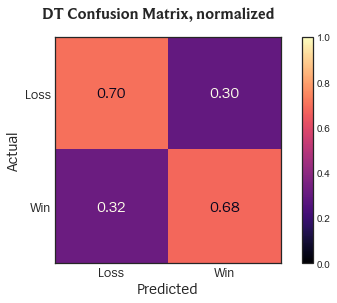

,Pred L,Pred W
True L,117,50
True W,52,111


In [59]:
# Confusion Matrix for Decision Tree, tuned model

# Compute confusion matrix
cnf_matrix_dt = confusion_matrix(target_test, target_predicted_dt)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_dt, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('DT Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_dt)

> ##### Interpreting the Confusion Matrix
> ___
> Rows across represent the Actual class of data items (classified as Win or Loss), while columns represent Predictions made by the model. The intersections of Actual and Predicted are normalized to contrast the percentages of the Actual value that were Predicted correctly vs. incorrectly.
>
> *Percentage (and color) normalization applies to rows only.*
>
> For example, if we go across the top row (Actual Loss), we see that 70% of Actual Losses were predicted correctly—known as **True Negatives**. <br>
> The remaining 30% of Actual Losses were misclassified as Wins by the model—these are **False Positives**.
>
> The same applies to the bottom row (Actual Win). <br> 
> 32% were misclassified as Losses—**False Negatives**, and 68% were predicted correctly—**True Positives**.
>
> 
> *The color scale reinforces the effectiveness and strength of predictions.*
>
> Ideally, we want to see rates of True Positives (and True Negatives) close to 1.0, coded light yellow. <br>
> Conversely, we want to minimize False Positives and False Negatives—values near zero are coded black / dark purple. <br>
> 
> A perfect matrix, then, would have 1.0 (light yellow) values in the top-left and bottom-right squares, and 0 (black) values in the remaining squares—creating a "checkered" pattern. This represents a figurative "night and day" difference between incorrect and correct predictions.
>
> The confusion matrix above exhibits this ideal checkered pattern, but with "sunrise and sunset" colors that indicate the degree of ambiguity between correct and incorrect predictions.
>
> The same matrix is then also presented in "traditional" table form with absolute counts.

[Back to Models](#models)

<br>

#### Extremely Random Trees (Extra Trees)
___
The Extra Trees Classifier uses a small group (ensemble) of decision trees, each with randomized parameters that result in different decision paths. The goal is to improve upon the results of a single decision tree by aggregating the predictions of a group.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default XT  |     77.13%    |<font color="green">+26.53%</font>|<font color="deeporange">19.31%</font>|
| Tuned XT    |     79.73%    |<font color="green">+29.13%</font>|<font color="darkorange">11.84%</font>|

In [60]:
# Extra Trees, base model
from sklearn.ensemble import ExtraTreesClassifier

# Define
clf_xt = ExtraTreesClassifier(random_state = 7)

# Fit
clf_xt.fit(features_train, target_train)

# Predict
target_predicted_xt = clf_xt.predict(features_test)

# Evaluate
model_results_default(clf_xt, target_predicted_xt, 'XT')

Default Parameters:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

XT Accuracy: 0.7727
XT Lift: 0.2667

             precision    recall  f1-score   support

       Loss       0.74      0.84      0.79       167
        Win       0.81      0.71      0.75       163

avg / total       0.78      0.77      0.77       330



In [61]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_xt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

print(cv_results(scores))

Cross Validation Score for each K:
[ 0.7821  0.7949  0.8333  0.7949  0.6753
  0.7013  0.7368  0.8684  0.8026  0.7237]

Range: 0.1931

Average: 0.7713
Lift: 0.2653



The default model uses 10 trees. Let's see what happens when we add more.

In [62]:
# Extra Trees, tuned model

# Define
clf_xt = ExtraTreesClassifier(criterion = 'gini', 
                              class_weight = 'balanced', 
                              n_estimators = 30, 
                              max_features = 28, 
                              min_samples_split = 11, 
                              random_state = 7)

# Fit
clf_xt.fit(features_train, target_train)

# Predict
target_predicted_xt = clf_xt.predict(features_test)

# Evaluate
model_results(clf_xt, target_predicted_xt, 'XT')

XT Accuracy: 0.7879
XT Lift: 0.2818

             precision    recall  f1-score   support

       Loss       0.78      0.80      0.79       167
        Win       0.79      0.77      0.78       163

avg / total       0.79      0.79      0.79       330



In [63]:
# Verify with 10-fold Cross-validation

scores = cross_val_score(clf_xt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

print(cv_results(scores))

Cross Validation Score for each K:
[ 0.8077  0.7821  0.8205  0.8333  0.7662
  0.7662  0.7237  0.8421  0.8421  0.7895]

Range: 0.1184

Average: 0.7973
Lift: 0.2913



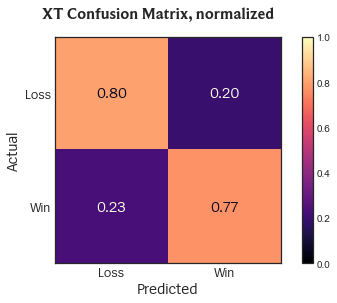

,Pred L,Pred W
True L,134,33
True W,37,126


In [64]:
# Confusion Matrix for Extra Trees, tuned model

# Compute confusion matrix
cnf_matrix_xt = confusion_matrix(target_test, target_predicted_xt)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_xt, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('XT Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_xt)

[Back to Models](#models)

<br>

#### Random Forest
___
As with Extra Trees, a Random Forest is an ensemble of decision trees. The key differences are the number of trees—500 by default—and the method of randomization. While XT randomized the parameters of the trees, the RF randomizes the sampling of data  (via "bootstrapping") used to train the trees.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default RF  |    80.52%    |<font color="green">+29.92%</font>|<font color="darkorange">11.89%</font> |
| Tuned RF    |    81.82%    |<font color="green">+31.21%</font>|<font color="yellowgreen">9.27%</font>  |

In [65]:
# Random Forest, base model
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()

# Define
clf_rf = RandomForestClassifier(n_estimators = 500, 
                                n_jobs = -1,
                                random_state = 7)

# Fit
clf_rf.fit(features_train, target_train)

# Predict
target_predicted_rf = clf_rf.predict(features_test)

# Evaluate
running_time()
model_results_default(clf_rf, target_predicted_rf, 'RF')

Running time: 00:00:01

Default Parameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

RF Accuracy: 0.8333
RF Lift: 0.3273

             precision    recall  f1-score   support

       Loss       0.83      0.84      0.84       167
        Win       0.83      0.83      0.83       163

avg / total       0.83      0.83      0.83       330



In [66]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_rf, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:09

Cross Validation Score for each K:
[ 0.8333  0.7949  0.8077  0.8462  0.7273
  0.7403  0.8158  0.8289  0.8421  0.8158]

Range: 0.1189

Average: 0.8052
Lift: 0.2992



Keep the number of trees at 500—much higher and the tradeoff between improvement and computing time becomes too costly—but implement some of the tuning parameters used earlier to optimize the single decision tree.

In [67]:
# Random Forest, tuned model
start_time = time.time()

# Define
clf_rf = RandomForestClassifier(criterion = 'gini', 
                                class_weight = 'balanced', 
                                n_estimators = 500, 
                                max_features = 18, 
                                min_samples_split = 12, 
                                n_jobs = -1,
                                random_state = 7)

# Fit
clf_rf.fit(features_train, target_train)

# Predict
target_predicted_rf = clf_rf.predict(features_test)

# Evaluate
running_time()
model_results(clf_rf, target_predicted_rf, 'RF')

Running time: 00:00:00

RF Accuracy: 0.8424
RF Lift: 0.3364

             precision    recall  f1-score   support

       Loss       0.84      0.84      0.84       167
        Win       0.84      0.84      0.84       163

avg / total       0.84      0.84      0.84       330



In [68]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_rf, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:09

Cross Validation Score for each K:
[ 0.8462  0.7949  0.8205  0.8590  0.7792
  0.7662  0.8026  0.8421  0.8553  0.8158]

Range: 0.0927

Average: 0.8182
Lift: 0.3121



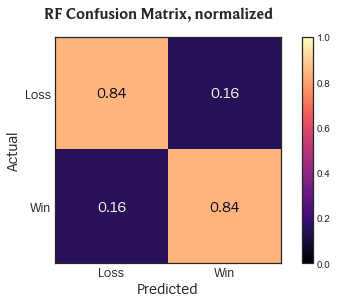

,Pred L,Pred W
True L,141,26
True W,26,137


In [69]:
# Confusion Matrix for Random Forest, tuned model

# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(target_test, target_predicted_rf)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('RF Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_rf)

<br>

##### Feature Importance

Decision tree models contain an attribute called `feature_importances_`, which measures the usefulness of each variable in splitting the "branches" of a decision tree. We can sidestep "predictive analytics" momentarily—into "descriptive analytics"—to understand a little better the variables that are driving these decisions.

In [70]:
# Get array of feature importance values from Random Forest model
importances = clf_rf.feature_importances_

# Get index of feature names (excluding the Target in column 0)
feature_names = df.columns[1:]

# Create a "long-form" dataframe
feature_importance_rf = pd.DataFrame(importances, 
                                     columns = ['importance'], 
                                     index = feature_names)

# Sort by highest importance
feature_importance_rf_sorted = feature_importance_rf.sort_values(by = 'importance', ascending = False)

# Cut off at top 10
feature_importance_rf_sorted_10 = feature_importance_rf_sorted.iloc[0:10, : ]

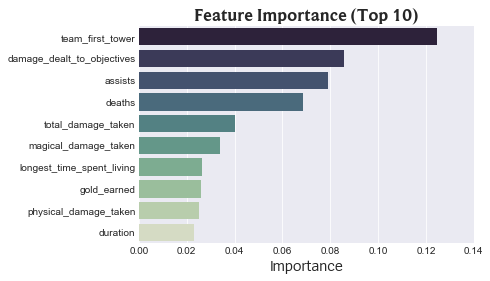

In [71]:
# Plot feature importance
sns.set_style('darkgrid')
pal = sns.cubehelix_palette(10, start=.5, rot=-.75, reverse = True)

ax = sns.barplot(x = 'importance', y = feature_importance_rf_sorted_10.index,
                 data = feature_importance_rf_sorted_10,
                 palette = pal)

plt.title('Feature Importance (Top 10)', fontproperties = main, fontsize = 18)
plt.xlabel('Importance', fontproperties = body, fontsize = 15)
plt.xlim(0, 0.14)
plt.show()

> ***League explained:*** *Feature Importance in Context*
> ___
> `team_first_tower` is a boolean value which indicates whether the player's team destroyed the first Tower (enemy turret) of the match. If false, the enemy team instead destroyed the player team's First Tower.
>
> "First Tower" represents an early advantage. For one, it provides bonus Gold to each player, allowing them to purchase items sooner. It also allows that team to push farther into enemy territory. Towers are defense turrets which automatically deal damage to enemies within a moderate range. The normal tactic is for the attacking Champions (human players) to allow friendly Minions to enter this range first and take the Tower damage—like pawns in a chess game—so Champions can deal damage to the Tower without being damaged themselves. However, a Tower will shift its focus immediately to a Champion if they attack an enemy Champion while under the Tower. A team loses a defensive advantage, therefore, when one of their Towers is destroyed.
>
> `damage_dealt_to_objectives` is related to the above. It includes damage done by the player to enemy Towers, along with other similar match objectives.
>
> `assists` are scored whenever the player participates in defeating an enemy Champion, whether directly (dealing damage) or indirectly (healing and shielding allies in combat).
>
> `deaths` and features of the type `_damage_taken` can be a function of both the Items a player purchases (to improve their defenses and survivability) and simple positional awareness—that is, "watch where you're standing, so you don't take avoidable damage".
>
> `gold_earned` is a function of the player's `kills`, `assists`, and `total_minions_killed`; their team's destruction of enemy Objectives; and of `duration`—gold is earned passively at a steady rate throughout the match.

<br>

***See the forest for the trees:*** *(Collective Intelligence)*

A single decision tree is a fairly good predictor. However, a group of decision trees can be excellent. Each tree is slightly different—starting at a random location in the data means that every tree will reach conclusions a little differently. When these trees are grouped into a single classifier, correct predictions tend to be reinforced, while random errors cancel out.

The result tends to be "more trees, better answers", and we can see that clearly by comparing the confusion matrices.

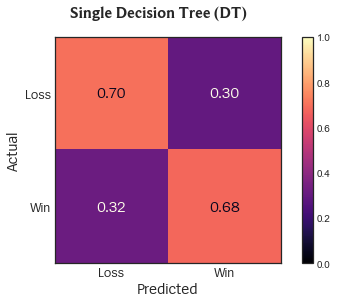

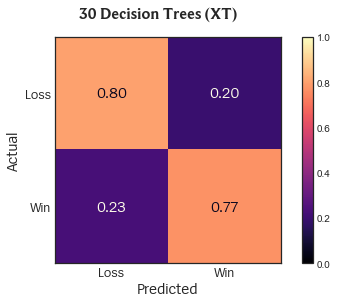

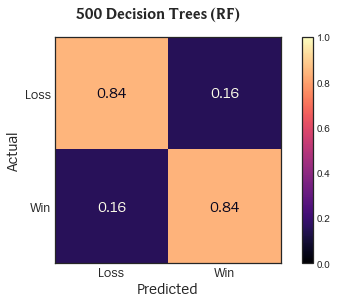

In [72]:
sns.set_style('white')

# Decision Tree
plt.figure()
plot_confusion_matrix(cnf_matrix_dt, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('Single Decision Tree (DT)', fontproperties = main, fontsize = 16)
plt.show()

# Extra Trees
plt.figure()
plot_confusion_matrix(cnf_matrix_xt, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('30 Decision Trees (XT)', fontproperties = main, fontsize = 16)
plt.show()

# Random Forest
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('500 Decision Trees (RF)', fontproperties = main, fontsize = 16)
plt.show()

The contrast between colors progressively increases as each model improves upon the one before—simply by adding more trees.

This illustrates the concept of "collective intelligence"—a proven phenomenon that makes a group of ordinary people smarter than a single expert. The foundation of collective intelligence was established with [Condorcet's *jury theorem*](https://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem) in the 18th century.

It states that:
> *If each voter is more likely than not to vote correctly (p > 0.50), <br>
> then adding more voters increases the probability that the majority decision is correct.*

[Swarm AI](https://unanimous.ai/insights-2017/) is a fascinaing example of how this is being applied to real-world questions, using human voters, instead of decision trees.

[Back to Models](#models)

<br>

#### Boosting on a Decision Tree
___
This model applies AdaBoost (adaptive boosting) to decision trees, adding weights to "call out" misclassified samples in an attempt to improve the success rate of subsequent iterations.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default BDT |     75.06%    |<font color="green">+24.45%</font>|<font color="darkorange">14.47%</font>|
|Partial Tuned BDT| 78.19%    |<font color="green">+27.59%</font>|<font color="darkorange">12.82%</font>|
|Fully Tuned BDT|   80.13%    |<font color="green">+29.53%</font>|<font color="deeporange">17.02%</font>|

In [73]:
# Boosting, base model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define
clf_bdt = AdaBoostClassifier(DecisionTreeClassifier(random_state = 7),
                             random_state = 7)
# Fit
clf_bdt.fit(features_train, target_train)

# Predict
target_predicted_bdt = clf_bdt.predict(features_test)

# Evaluate
model_results_default(clf_bdt, target_predicted_bdt, 'BDT')

Default Parameters:
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=7)

BDT Accuracy: 0.7515
BDT Lift: 0.2455

             precision    recall  f1-score   support

       Loss       0.77      0.72      0.75       167
        Win       0.73      0.78      0.76       163

avg / total       0.75      0.75      0.75       330



> Printing the default parameters tells us that the base Boosting model uses 50 trees (`n_estimators=50`)

In [74]:
# Verify with 10-fold Cross-validation
scores = cross_val_score(clf_bdt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

print(cv_results(scores))

Cross Validation Score for each K:
[ 0.7949  0.7179  0.7051  0.7821  0.7532
  0.7922  0.7368  0.7632  0.8026  0.6579]

Range: 0.1447

Average: 0.7506
Lift: 0.2445



Tuning only the parameters for the underlying tree (identical to the tuning of the single decision tree), we get . . .

In [75]:
# Boosting, tuned learner
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define
clf_bdt = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'gini', 
                                                    class_weight = 'balanced',  
                                                    max_features = 28, 
                                                    min_samples_split = 11, 
                                                    random_state = 7),
                             random_state = 7)
# Fit
clf_bdt.fit(features_train, target_train)

# Predict
target_predicted_bdt = clf_bdt.predict(features_test)

# Evaluate
model_results(clf_bdt, target_predicted_bdt, 'BDT')

BDT Accuracy: 0.8121
BDT Lift: 0.3061

             precision    recall  f1-score   support

       Loss       0.79      0.85      0.82       167
        Win       0.83      0.77      0.80       163

avg / total       0.81      0.81      0.81       330



In [76]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_bdt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:01

Cross Validation Score for each K:
[ 0.7692  0.7051  0.7821  0.8333  0.8312
  0.7273  0.7368  0.8026  0.8158  0.8158]

Range: 0.1282

Average: 0.7819
Lift: 0.2759



We can also adjust the parameters for the overall AdaBoost model. These are `n_estimators` and `learning_rate`.

The first parameter is easy. More trees are better, right? <br>
Learning rate is more complicated, though. This reflects the weight that AdaBoost assigns to values misclassified by one tree in an effort to "learn" from mistakes with the next tree.

`GridSearchCV` can be used to iterate through a range of possible values for `learning_rate`. The grid search will print the best parameter in its range, based on the average Accuracy from 10-fold cross-validation.

In [77]:
# Grid search for Boosting
start_time = time.time()

# Define the model to test
clf_bdt = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'gini', 
                                                    class_weight = 'balanced',  
                                                    max_features = 28, 
                                                    min_samples_split = 11, 
                                                    random_state = 7), 
                             n_estimators = 100, 
                             random_state = 7)

# Define range of parameters
param_grid = {
    'learning_rate': np.arange(0.25, 2.50, # Search range
                               0.01)       # Search increments
}

# Run grid search with 10-fold CV
grid_search = GridSearchCV(clf_bdt,  # <- Specify model to use
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           n_jobs = -1,  # Parallel processing. -1 to use all available cores
                           cv = 10)

grid_search.fit(features_train, target_train)

running_time()
print("Best Score: {0: .4f}".format(grid_search.best_score_))
print("Best Params: {}".format(grid_search.best_params_))

Running time: 00:03:08

Best Score:  0.8182
Best Params: {'learning_rate': 1.360000000000001}


Plug in the best result, `learning_rate = 1.36`, and dial up the trees to 500.

In [78]:
# Boosting, tuned learner and model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()

# Define
clf_bdt = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'gini', 
                                                    class_weight = 'balanced',  
                                                    max_features = 28, 
                                                    min_samples_split = 11, 
                                                    random_state = 7), 
                             n_estimators = 500, 
                             learning_rate = 1.36,
                             random_state = 7)
# Fit
clf_bdt.fit(features_train, target_train)

# Predict
target_predicted_bdt = clf_bdt.predict(features_test)

# Evaluate
running_time()
model_results(clf_bdt, target_predicted_bdt, 'BDT')

Running time: 00:00:01

BDT Accuracy: 0.8364
BDT Lift: 0.3303

             precision    recall  f1-score   support

       Loss       0.83      0.85      0.84       167
        Win       0.84      0.82      0.83       163

avg / total       0.84      0.84      0.84       330



In [79]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_bdt, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:16

Cross Validation Score for each K:
[ 0.8205  0.7564  0.7821  0.8974  0.7273
  0.7532  0.8026  0.7895  0.8421  0.8421]

Range: 0.1702

Average: 0.8013
Lift: 0.2953



> Although the grid search used CV to find the `learning_rate` parameter that gave the best average accuracy, it seems not to have accounted for the spread of individual CV results.

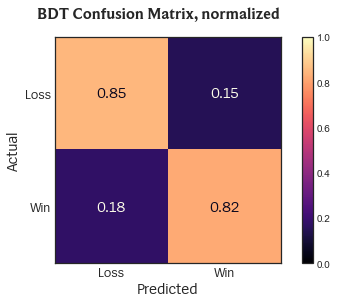

,Pred L,Pred W
True L,142,25
True W,29,134


In [80]:
# Confusion Matrix for Boosting, tuned model

# Compute confusion matrix
cnf_matrix_bdt = confusion_matrix(target_test, target_predicted_bdt)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bdt, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('BDT Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_bdt)

[Back to Models](#models)

<br>

#### Gradient Boosting
___

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default GBC |     80.79%    |<font color="green">+30.18%</font>|<font color="darkorange">10.20%</font>|
| Tuned GBC   |     81.05%    |<font color="green">+30.44%</font>|<font color="yellowgreen">7.59%</font>|

In [81]:
# Gradient Boosting, base model
from sklearn.ensemble import GradientBoostingClassifier

# Define
clf_gbc = GradientBoostingClassifier(random_state = 7)

# Fit
clf_gbc.fit(features_train, target_train)

# Predict
target_predicted_gbc = clf_gbc.predict(features_test)

# Evaluate
model_results_default(clf_gbc, target_predicted_gbc, 'GBC')

Default Parameters:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=7, subsample=1.0, verbose=0,
              warm_start=False)

GBC Accuracy: 0.8606
GBC Lift: 0.3545

             precision    recall  f1-score   support

       Loss       0.88      0.84      0.86       167
        Win       0.85      0.88      0.86       163

avg / total       0.86      0.86      0.86       330



In [82]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_gbc, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:04

Cross Validation Score for each K:
[ 0.8333  0.7949  0.7821  0.8205  0.7532
  0.7922  0.8158  0.8553  0.8421  0.7895]

Range: 0.1020

Average: 0.8079
Lift: 0.3018



> These are some of the best results so far, and this is only the default model.
>
> Let's see where tuning will take us.

In [83]:
# Gradient Boosting, tuned model
from sklearn.ensemble import GradientBoostingClassifier

# Define
clf_gbc = GradientBoostingClassifier(learning_rate = 0.10, 
                                     n_estimators = 200, 
                                     min_samples_split = 15, 
                                     min_samples_leaf = 3,
                                     random_state = 7)

# Fit
clf_gbc.fit(features_train, target_train)

# Predict
target_predicted_gbc = clf_gbc.predict(features_test)

# Evaluate
model_results(clf_gbc, target_predicted_gbc, 'GBC')

GBC Accuracy: 0.8485
GBC Lift: 0.3424

             precision    recall  f1-score   support

       Loss       0.84      0.86      0.85       167
        Win       0.86      0.83      0.84       163

avg / total       0.85      0.85      0.85       330



In [84]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_gbc, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:08

Cross Validation Score for each K:
[ 0.8077  0.7821  0.8077  0.8333  0.8052
  0.7662  0.8026  0.8289  0.8421  0.8289]

Range: 0.0759

Average: 0.8105
Lift: 0.3044



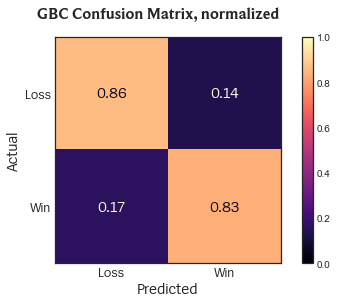

,Pred L,Pred W
True L,144,23
True W,27,136


In [85]:
# Confusion Matrix for Gradient Boosting, tuned model

# Compute confusion matrix
cnf_matrix_gbc = confusion_matrix(target_test, target_predicted_gbc)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_gbc, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('GBC Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_gbc)

[Back to Models](#models)

<br>

#### Bagging
___
Actually short for "Bootstrap aggregating", bagging involves sampling the dataset at random "with replacement", i.e. the same item can be drawn into a sample more than once. The decision trees trained on these "bootstrapped" data samples are then aggregated to make final predictions.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
| Default BAG |     79.87%    |<font color="green">+29.26%</font>|<font color="deeporange">17.99%</font>|
|   Tuned BAG |     80.78%    |<font color="green">+30.18%</font>|<font color="yellowgreen">8.27%</font>|

In [86]:
# Bagging, base model
from sklearn.ensemble import BaggingClassifier
start_time = time.time()

# Define
clf_bag = BaggingClassifier(n_jobs = -1,
                            random_state = 7)

# Fit
clf_bag.fit(features_train, target_train)

# Predict
target_predicted_bag = clf_bag.predict(features_test)

# Evaluate
running_time()
model_results_default(clf_bag, target_predicted_bag, 'BAG')

Running time: 00:00:18

Default Parameters:
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=-1, oob_score=False, random_state=7,
         verbose=0, warm_start=False)

BAG Accuracy: 0.8212
BAG Lift: 0.3152

             precision    recall  f1-score   support

       Loss       0.84      0.80      0.82       167
        Win       0.80      0.85      0.82       163

avg / total       0.82      0.82      0.82       330



In [87]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_bag, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:02:11

Cross Validation Score for each K:
[ 0.8205  0.8077  0.7821  0.8205  0.6753
  0.8442  0.8026  0.8553  0.8289  0.7500]

Range: 0.1799

Average: 0.7987
Lift: 0.2926



Adjusting some parameters:

In [88]:
# Bagging, tuned model
from sklearn.ensemble import BaggingClassifier
start_time = time.time()

# Define
clf_bag = BaggingClassifier(n_estimators = 500, 
                            max_features = 0.9, 
                            max_samples = 0.8,
                            n_jobs = -1,
                            random_state = 7)

# Fit
clf_bag.fit(features_train, target_train)

# Predict
target_predicted_bag = clf_bag.predict(features_test)

# Evaluate
running_time()
model_results(clf_bag, target_predicted_bag, 'BAG')

Running time: 00:00:13

BAG Accuracy: 0.8455
BAG Lift: 0.3394

             precision    recall  f1-score   support

       Loss       0.85      0.84      0.85       167
        Win       0.84      0.85      0.84       163

avg / total       0.85      0.85      0.85       330



In [89]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_bag, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:02:31

Cross Validation Score for each K:
[ 0.7949  0.8077  0.7821  0.8590  0.7792
  0.7922  0.7763  0.8289  0.8421  0.8158]

Range: 0.0827

Average: 0.8078
Lift: 0.3018



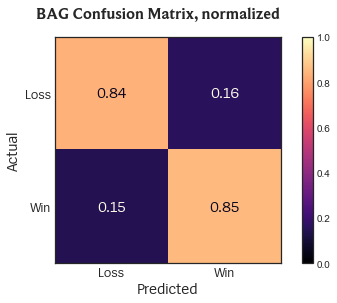

,Pred L,Pred W
True L,140,27
True W,24,139


In [90]:
# Confusion Matrix for Bagging, tuned model

# Compute confusion matrix
cnf_matrix_bag = confusion_matrix(target_test, target_predicted_bag)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_bag, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('BAG Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_bag)

[Back to Models](#models)

<br>

#### Logistic Regression
___

<center><i>Results in Brief</i></center>

|    **Model**     |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|------------------|---------------|----------------------------------|-----------------------------|
| Default LOG (L2) |     83.65%    |<font color="green">+33.05%</font>|<font color="deeporange">15.46%</font>|
|   Tuned LOG (L2) |     80.13%    |<font color="green">+29.53%</font>|<font color="yellowgreen">8.97%</font>|
|   Tuned LOG (L1) |     80.66%    |<font color="green">+30.05%</font>|<font color="yellowgreen">7.29%</font>|

All the classifier models up to this point have been based on the Decision Tree. Although subsequent models improved greatly upon the results of a single tree, the overall pattern of results remained very similar.

Now, we will examine some entirely different classes of models. The first is Logistic Regression. While decision trees predict by splitting data into a hierarchy of yes/no decision paths, Logistic Regression predicts by estimating the ***probability*** of an outcome (in this case, a Win or Loss).

Logistic Regression employs special normalization algorithms that adjust weights of each individual variable based on its importance. This is where the [scaled](#prep) dataset will come into play. By adjusting all variables to the same scale—from 0 to 1—we ensure that some variabled won't dominate simply by virtue of measuring larger numbers. 

For example, the `kills` variable has a range (0, 31), while `total_damage_dealt` has a range of ~ 6,000 to 300,000. (see [Summary Stats](#special-prep) for full details). Scaling puts these vastly different measurements on equal footing.

In [91]:
# Logistic Regression, base model
from sklearn.linear_model import LogisticRegression
start_time = time.time()

# Define
clf_log = LogisticRegression(random_state = 7)

# Fit
clf_log.fit(features_train_scaled, target_train)

# Predict
target_predicted_log = clf_log.predict(features_test_scaled)

# Evaluate
running_time()
model_results_default(clf_log, target_predicted_log, 'LOG')

Running time: 00:00:00

Default Parameters:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LOG Accuracy: 0.7667
LOG Lift: 0.2606

             precision    recall  f1-score   support

       Loss       0.76      0.78      0.77       167
        Win       0.77      0.75      0.76       163

avg / total       0.77      0.77      0.77       330



In [92]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_log, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:01

Cross Validation Score for each K:
[ 0.8846  0.7564  0.8077  0.8718  0.7532
  0.8442  0.8026  0.8947  0.9079  0.8421]

Range: 0.1546

Average: 0.8365
Lift: 0.3305



In [93]:
# Logistic Regression, tuned model (L2 penalty)
from sklearn.linear_model import LogisticRegression
start_time = time.time()

# Define
clf_log_l2 = LogisticRegression(solver = 'saga', 
                                penalty = 'l2',
                                class_weight = None, 
                                C = 0.75, 
                                max_iter = 10000,
                                n_jobs = -1,
                                random_state = 7)

# Fit
clf_log_l2.fit(features_train_scaled, target_train)

# Predict
target_predicted_log_l2 = clf_log_l2.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_log_l2, target_predicted_log_l2, 'LOG-L2')

Running time: 00:00:00

LOG-L2 Accuracy: 0.7727
LOG-L2 Lift: 0.2667

             precision    recall  f1-score   support

       Loss       0.77      0.78      0.78       167
        Win       0.77      0.77      0.77       163

avg / total       0.77      0.77      0.77       330



In [94]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_log_l2, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:03

Cross Validation Score for each K:
[ 0.7436  0.8333  0.8205  0.7821  0.7922
  0.8312  0.7500  0.8289  0.8158  0.8158]

Range: 0.0897

Average: 0.8013
Lift: 0.2953



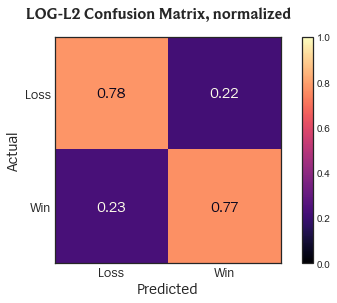

,Pred L,Pred W
True L,130,37
True W,38,125


In [95]:
# Confusion Matrix for Logistic Regression-L2, tuned model

# Compute confusion matrix
cnf_matrix_log_l2 = confusion_matrix(target_test, target_predicted_log_l2)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_log_l2, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('LOG-L2 Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_log_l2)

The default regularization for Logistic Regression is an L2 penalty. This adjusts coefficients based on their predictive power—giving less weight to ineffective predictors. 

While L2 can adjust the weights of coefficients, it still allows the entire set of features to be used in prediction. The L1 penalty goes a step further. With this option, coefficients can actually be set equal to zero, excluding them entirely from the final prediction. The advantage of this is that it is a type of "automatic feature selection"—removing unnecessary variables for an overall simpler model.

In [96]:
# Logistic Regression, tuned model (L1 penalty)
from sklearn.linear_model import LogisticRegression
start_time = time.time()

# Define
clf_log_l1 = LogisticRegression(solver = 'saga', 
                                penalty = 'l1',
                                class_weight = None, 
                                C = 0.30, 
                                max_iter = 10000,
                                n_jobs = -1,
                                random_state = 7)

# Fit
clf_log_l1.fit(features_train_scaled, target_train)

# Predict
target_predicted_log_l1 = clf_log_l1.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_log_l1, target_predicted_log_l1, 'LOG-L1')

Running time: 00:00:00

LOG-L1 Accuracy: 0.8030
LOG-L1 Lift: 0.2970

             precision    recall  f1-score   support

       Loss       0.80      0.82      0.81       167
        Win       0.81      0.79      0.80       163

avg / total       0.80      0.80      0.80       330



In [97]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_log_l1, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:03

Cross Validation Score for each K:
[ 0.7692  0.8333  0.7692  0.8333  0.7792
  0.8312  0.7763  0.8158  0.8158  0.8421]

Range: 0.0729

Average: 0.8066
Lift: 0.3005



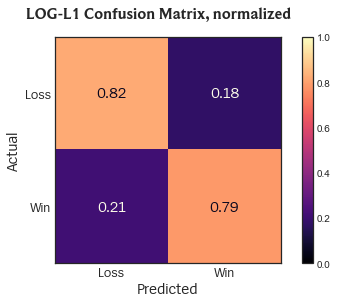

,Pred L,Pred W
True L,137,30
True W,35,128


In [98]:
# Confusion Matrix for Logistic Regression-L1, tuned model

# Compute confusion matrix
cnf_matrix_log_l1 = confusion_matrix(target_test, target_predicted_log_l1)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_log_l1, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('LOG-L1 Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_log_l1)

We can print an array of coefficients to see the kind of effect that the L1 penalty has. <br>
Out of almost 300 features, the model only uses a handful—the rest have been deemed "not significant predictors" and were excluded.

In [99]:
np.set_printoptions(precision = 5,
                    suppress = True, 
                    linewidth = 80)

print(clf_log_l1.coef_)

[[-0.218    0.32092  1.84781  0.       0.       0.      -4.81501  4.28927
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.18655  0.       0.       2.54905  0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.3179   0.      -0.1967   0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.      -0.08466  0.       0.       0.
   0.       0.       0.      

These can be viewed in a dataframe alongside their respective feature names.

In [100]:
# Get array of coefficients from Logistic Regression model
coeffs = clf_log_l1.coef_

# Transpose into long form
coeffs = coeffs.transpose()

# Get index of feature names (excluding the Target in column 0)
feature_names = df.columns[1:]

# Create a "long-form" dataframe
coeffs_table = pd.DataFrame(coeffs, 
                            columns = ['coefficient'], 
                            index = feature_names)

# Exclude zero coefficients
coeffs_table = coeffs_table[coeffs_table['coefficient'] != 0]

In [101]:
# View
coeffs_table

,coefficient
duration,-0.217997
team_first_blood,0.320915
team_first_tower,1.847812
deaths,-4.815013
assists,4.289272
largest_killing_spree,0.186546
damage_dealt_to_objectives,2.549045
tmate_Fiddlesticks,0.317898
tmate_Fizz,-0.196701
tmate_Nidalee,-0.084661


> These are interesting, because we get a much different set of important variables than what we saw with the decision trees. It shows that team comp, i.e. my Champion and the other Champions on my team, can have some real predictive power.
>
> Unfortunately, the coefficient values themselves have almost no meaning—there are several layers of complex math standing between us and any kind of practical interpretation. However, I thought the signs of the coefficients, at the very least, would be of some help.
>
> Some of them do seem intuitive—`deaths` is negative, while `assists` is positive. It makes perfect sense to assume that more deaths decreases the probability of a Win, while more assists increases it.
>
> Then I got to this:

In [102]:
coeffs_table[coeffs_table.index == 'champion_Lux']

,coefficient
champion_Lux,-0.429962


> Lux is one of my favorites to play! Surely she's not negatively affecting my chances of winning.

In [103]:
# Crosstab of win rate by Lux games
lux_tab = pd.crosstab(df['champion_Lux'], df_orig['win'],
                      rownames = ['Played as Lux'], colnames = ['Win'],
                      normalize = 'index')

lux_tab

Win,False,True
Played as Lux,,
0,0.506654,0.493346
1,0.375000,0.625000


> Sure enough, my win rate when I play as Lux is 62.5%—compared to just under 50% when I play as any other Champion. This is proof that Logistic Regression coefficients are not to be trusted. All we can easily learn from them is that they're either important (not zero) or they're not.
>
> This is also, as it just so happens, a perfect transition into Bayesian conditional probability.

[Back to Models](#models)

<br>

#### Naïve Bayes
___

<center><i>Results in Brief</i></center>

|       **Model**      |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|----------------------|---------------|----------------------------------|-----------------------------|
| NB Gaussian          |     71.31%    |<font color="green">+20.71%</font>|<font color="deeporange">19.24%</font>|
| Default NB Bernoulli |     70.78%    |<font color="green">+20.17%</font>|<font color="yellowgreen">7.69%</font>|
|   Tuned NB Bernoulli |     74.27%    |<font color="green">+23.66%</font>|<font color="yellowgreen">8.47%</font>|

Bayesian models operate on the principle of conditional probability. Simply put, this is the evaluation of new information and how it changes the probability of an outcome.

The following is a short example of how conditional probability can be applied.

In [104]:
# Crosstab of win rate by First Tower
tower_tab = pd.crosstab(df_orig['team_first_tower'], df_orig['win'],
                        rownames = ['First Tower'], colnames = ['Win'],
                        normalize = 'index')

tower_tab

Win,False,True
First Tower,,
False,0.766355,0.233645
True,0.249558,0.750442


Let's assume that the probability of a player winning their next match, based on past history, is exactly 50%. This is the **Prior probability**. Keep in mind, this hypothetical match hasn't started yet, so we have no data on it.

Now assume that the match has begun, and the player's team has just claimed First Tower. According to their match history, they have won 75% of matches where their team has claimed First Tower. Therefore, the **Posterior probability** of winning this match, given the new information we just gained, has become 75%.

In reality, Bayesian classifier models are better suited to predictive applications in text mining, due to the way that data is structured. However, we can still apply these models in this situation.

In [105]:
# Naïve Bayes, Gaussian
from sklearn.naive_bayes import GaussianNB
start_time = time.time()

# Define
clf_nbg = GaussianNB()

# Fit
clf_nbg.fit(features_train, target_train)

# Predict
target_predicted_nbg = clf_nbg.predict(features_test)

# Evaluate
running_time()
model_results(clf_nbg, target_predicted_nbg, 'NB-G')

Running time: 00:00:00

NB-G Accuracy: 0.7182
NB-G Lift: 0.2121

             precision    recall  f1-score   support

       Loss       0.75      0.66      0.70       167
        Win       0.69      0.77      0.73       163

avg / total       0.72      0.72      0.72       330



In [106]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_nbg, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7564  0.6667  0.6923  0.7564  0.6494
  0.6234  0.7105  0.8158  0.7237  0.7368]

Range: 0.1924

Average: 0.7131
Lift: 0.2071



> The Range (overfitting) is way too high.
>
> The Gaussian model has no parameters for tuning.

Let's instead try another variant, Bernoulli NB. This model is better-suited for data with binary features (the majority of the features in this dataset are binary), and it also has a few tuning parameters available.

In [107]:
# Naïve Bayes, Bernoulli, base model
from sklearn.naive_bayes import BernoulliNB
start_time = time.time()

# Define
clf_nbb = BernoulliNB()

# Fit
clf_nbb.fit(features_train, target_train)

# Predict
target_predicted_nbb = clf_nbb.predict(features_test)

# Evaluate
running_time()
model_results_default(clf_nbb, target_predicted_nbb, 'NB-B')

Running time: 00:00:00

Default Parameters:
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

NB-B Accuracy: 0.7515
NB-B Lift: 0.2455

             precision    recall  f1-score   support

       Loss       0.76      0.75      0.75       167
        Win       0.75      0.75      0.75       163

avg / total       0.75      0.75      0.75       330



In [108]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_nbb, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7051  0.6795  0.7564  0.7051  0.6883
  0.7143  0.6974  0.7237  0.6842  0.7237]

Range: 0.0769

Average: 0.7078
Lift: 0.2017



> Accuracy is good, and Range is significantly improved over the Gaussian model.

We'll run grid search to determine the best values for the tuning parameters.

In [109]:
# Grid search for Naïve Bayes, Bernoulli
start_time = time.time()

# Define the model to test
clf_nbb = BernoulliNB()

# Define range of parameters
param_grid = {
    'alpha': np.arange(0, 10,   # Search range
                       0.1),    # Search increments
    'binarize': np.arange(0, 1,     # Search range
                          0.1),     # Search increments
}

# Run grid search with 10-fold CV
grid_search = GridSearchCV(clf_nbb,  # <- Specify model to use
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           n_jobs = -1,  # Parallel processing. -1 to use all available cores
                           cv = 10)

grid_search.fit(features_train, target_train)

running_time()
print("Best Score: {0: .4f}".format(grid_search.best_score_))
print("Best Params: {}".format(grid_search.best_params_))

Running time: 00:00:59

Best Score:  0.7429
Best Params: {'alpha': 7.6000000000000005, 'binarize': 0.0}


In [110]:
# Naïve Bayes, Bernoulli, tuned model
start_time = time.time()

# Define
clf_nbb = BernoulliNB(alpha = 7.6, 
                      binarize = 0)

# Fit
clf_nbb.fit(features_train, target_train)

# Predict
target_predicted_nbb = clf_nbb.predict(features_test)

# Evaluate
running_time()
model_results(clf_nbb, target_predicted_nbb, 'NB-B')

Running time: 00:00:00

NB-B Accuracy: 0.7576
NB-B Lift: 0.2515

             precision    recall  f1-score   support

       Loss       0.78      0.73      0.75       167
        Win       0.74      0.79      0.76       163

avg / total       0.76      0.76      0.76       330



In [111]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_nbb, features_train, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7179  0.7692  0.7821  0.7564  0.7273
  0.7662  0.6974  0.7368  0.7500  0.7237]

Range: 0.0847

Average: 0.7427
Lift: 0.2366



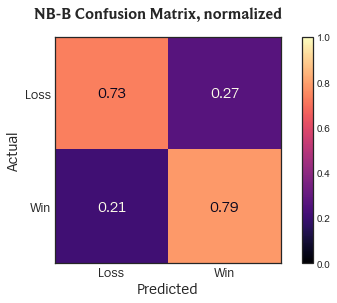

,Pred L,Pred W
True L,122,45
True W,35,128


In [112]:
# Confusion Matrix for Naïve Bayes, Bernoulli, tuned model

# Compute confusion matrix
cnf_matrix_nbb = confusion_matrix(target_test, target_predicted_nbb)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_nbb, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('NB-B Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_nbb)

> We ended with a fairly strong result, comparable to other top-performing models already tested.

[Back to Models](#models)

<br>

#### k-Nearest Neighbors (KNN)
___
Known as a "lazy learner", KNN predicts by comparing an unknown classification to the most similar items in the training data. "k" is a user-defined variable for the number of "nearest neighbors" to compare against.

<center><i>Results in Brief</i></center>

|   **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|---------------|---------------|----------------------------------|-----------------------------|
| Default KNN-5 |     68.29%    |<font color="green">+17.69%</font>|<font color="deeporange">16.40%</font>|
|  Tuned KNN-15 |     73.51%    |<font color="green">+22.91%</font>|<font color="yellowgreen">7.09%</font>|
|  Tuned KNN-36 |     75.98%    |<font color="green">+25.37%</font>|<font color="darkorange">10.53%</font>|

Because KNN calculates distances to determine the most similar observations, we want to be sure and always use the scaled data, `features_train_scaled` and `features_test_scaled`, for fitting, predicting, and validating.

In [113]:
# KNN, base model
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()

# Define
clf_knn = KNeighborsClassifier()

# Fit
clf_knn.fit(features_train_scaled, target_train)

# Predict
target_predicted_knn = clf_knn.predict(features_test_scaled)

# Evaluate
running_time()
model_results_default(clf_knn, target_predicted_nbb, 'KNN')

Running time: 00:00:00

Default Parameters:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNN Accuracy: 0.7576
KNN Lift: 0.2515

             precision    recall  f1-score   support

       Loss       0.78      0.73      0.75       167
        Win       0.74      0.79      0.76       163

avg / total       0.76      0.76      0.76       330



In [114]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_knn, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.6410  0.7692  0.6410  0.7436  0.6883
  0.6883  0.6053  0.6711  0.7237  0.6579]

Range: 0.1640

Average: 0.6829
Lift: 0.1769



##### Grid Search

In [115]:
# Grid search for KNN
start_time = time.time()

# Define the model to test
clf_knn = KNeighborsClassifier()

# Define range of parameters
param_grid = {
    'n_neighbors': range(3, 50,   # Search range
                         1),      # Search increments
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

# Run grid search with 10-fold CV
grid_search = GridSearchCV(clf_knn,  # <- Specify model to use
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           n_jobs = -1,  # Parallel processing. -1 to use all available cores
                           cv = 10)

grid_search.fit(features_train_scaled, target_train)

running_time()
print("Best Score: {0: .4f}".format(grid_search.best_score_))
print("Best Params: {}".format(grid_search.best_params_))

Running time: 00:02:26

Best Score:  0.7623
Best Params: {'n_neighbors': 43, 'p': 1, 'weights': 'uniform'}


Based on the grid search results, I tried several different values of *k* to manually optimize the CV Spread and reduce overfitting. 

The two best models are below.

##### k = 15

In [116]:
# KNN, tuned model, k = 15
start_time = time.time()

# Define
clf_knn_15 = KNeighborsClassifier(n_neighbors = 15, 
                                  p = 1, 
                                  weights = 'uniform')

# Fit
clf_knn_15.fit(features_train_scaled, target_train)

# Predict
target_predicted_knn_15 = clf_knn_15.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_knn_15, target_predicted_nbb, 'KNN-15')

Running time: 00:00:00

KNN-15 Accuracy: 0.7576
KNN-15 Lift: 0.2515

             precision    recall  f1-score   support

       Loss       0.78      0.73      0.75       167
        Win       0.74      0.79      0.76       163

avg / total       0.76      0.76      0.76       330



In [117]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_knn_15, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7436  0.6923  0.7436  0.7564  0.7143
  0.7273  0.7237  0.7237  0.7632  0.7632]

Range: 0.0709

Average: 0.7351
Lift: 0.2291



##### k = 36

In [118]:
# KNN, tuned model, k = 36
start_time = time.time()

# Define
clf_knn_36 = KNeighborsClassifier(n_neighbors = 36, 
                                  p = 1, 
                                  weights = 'uniform')

# Fit
clf_knn_36.fit(features_train_scaled, target_train)

# Predict
target_predicted_knn_36 = clf_knn_36.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_knn_36, target_predicted_nbb, 'KNN-36')

Running time: 00:00:00

KNN-36 Accuracy: 0.7576
KNN-36 Lift: 0.2515

             precision    recall  f1-score   support

       Loss       0.78      0.73      0.75       167
        Win       0.74      0.79      0.76       163

avg / total       0.76      0.76      0.76       330



In [119]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_knn_36, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7308  0.7308  0.7692  0.7949  0.7273
  0.7792  0.6974  0.8026  0.7895  0.7763]

Range: 0.1053

Average: 0.7598
Lift: 0.2537



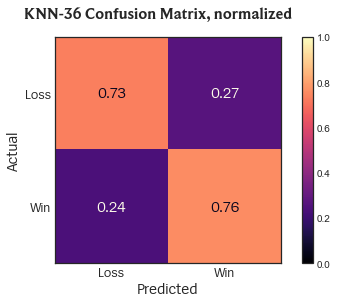

,Pred L,Pred W
True L,122,45
True W,39,124


In [120]:
# Confusion Matrix for KNN, k = 36

# Compute confusion matrix
cnf_matrix_knn_36 = confusion_matrix(target_test, target_predicted_knn_36)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_knn_36, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('KNN-36 Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_knn_36)

[Back to Models](#models)

<br>

#### Ensemble Voting (Stacking)
___
This is simply a method which combines ("stacks") a number of existing models and then makes final predictions based on the "majority vote" of the component models.

For this example, we're creating an ensemble from the random forest, gradient boosting, bagging, naïve Bayes, and logistic regression models already evaluated.

<center><i>Results in Brief</i></center>

| **Model**   |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-------------|---------------|----------------------------------|-----------------------------|
|    STK-5    |     82.08%    |<font color="green">+31.47%</font>|<font color="yellowgreen">8.92%</font>|

In [121]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [122]:
# Stacking (Ensemble Voting Classifier)
# Takes ~ 15 minutes
start_time = time.time()

# Define
### Random Forest
clf_rf = RandomForestClassifier(criterion = 'gini', 
                                class_weight = 'balanced', 
                                n_estimators = 500, 
                                max_features = 18, 
                                min_samples_split = 12, 
                                n_jobs = -1,
                                random_state = 7)

### Gradient Boosting
clf_gbc = GradientBoostingClassifier(learning_rate = 0.10, 
                                     n_estimators = 200, 
                                     min_samples_split = 15, 
                                     min_samples_leaf = 3,
                                     random_state = 7)

### Bagging
clf_bag = BaggingClassifier(n_estimators = 500, 
                            max_features = 0.9, 
                            max_samples = 0.8,
                            n_jobs = -1,
                            random_state = 7)

### Naïve Bayes, Bernoulli
clf_nbb = BernoulliNB(alpha = 7.6, 
                      binarize = 0)

### Logistic Regression, L1
clf_log_l1 = LogisticRegression(solver = 'saga', 
                                penalty = 'l1',
                                class_weight = None, 
                                C = 0.30, 
                                max_iter = 10000,
                                n_jobs = -1,
                                random_state = 7)



### Ensemble
eclf = VotingClassifier(estimators = [('rf', clf_rf), 
                                      ('gbc', clf_gbc), 
                                      ('bag', clf_bag), 
                                      ('nbb', clf_nbb), 
                                      ('log_l1', clf_log_l1)], 
                        voting = 'hard', 
                        n_jobs = -1)

# Summarize
for MV, label in zip([clf_log_l1],
                     ['Logistic Regression']): # Run logistic Reg separately because it needs to use the Scaled data

    scores = cross_val_score(MV, features_train_scaled, target_train, 
                             cv = 5, 
                             scoring = 'accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))
    
for MV, label in zip([clf_rf, clf_gbc, clf_bag, clf_nbb, 
                      eclf],
                     ['Random Forest', 'Gradient Boosting', 'Bagging', 'Naïve Bayes, Bernoulli', 
                      'Ensemble']):

    scores = cross_val_score(MV, features_train, target_train,
                             cv = 5,
                             scoring = 'accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))
    
print("")
running_time()

Accuracy: 0.7975 (+/- 0.0221) [Logistic Regression]
Accuracy: 0.8026 (+/- 0.0236) [Random Forest]
Accuracy: 0.8196 (+/- 0.0281) [Gradient Boosting]
Accuracy: 0.8117 (+/- 0.0209) [Bagging]
Accuracy: 0.7468 (+/- 0.0233) [Naïve Bayes, Bernoulli]
Accuracy: 0.8156 (+/- 0.0202) [Ensemble]

Running time: 00:04:12



''

In [123]:
# Ensemble Voting, continued
start_time = time.time()

# Fit
eclf.fit(features_train, target_train)

# Predict
target_predicted_eclf = eclf.predict(features_test)

# Evaluate
running_time()
model_results(eclf, target_predicted_eclf, 'STK')

Running time: 00:00:46

STK Accuracy: 0.8455
STK Lift: 0.3394

             precision    recall  f1-score   support

       Loss       0.85      0.84      0.85       167
        Win       0.84      0.85      0.84       163

avg / total       0.85      0.85      0.85       330



> Note how long it took this model just to fit to the data and make predictions—45 seconds, compared to the instant results of other models.

In [124]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(eclf, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:02:41

Cross Validation Score for each K:
[ 0.7949  0.8333  0.8205  0.8590  0.8052
  0.7792  0.7895  0.8289  0.8684  0.8289]

Range: 0.0892

Average: 0.8208
Lift: 0.3147



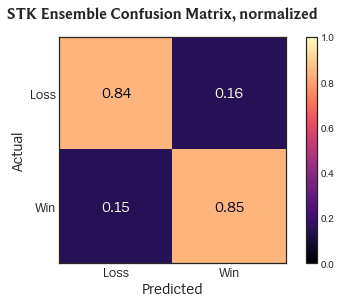

,Pred L,Pred W
True L,141,26
True W,25,138


In [125]:
# Confusion Matrix for Ensemble Voting

# Compute confusion matrix
cnf_matrix_eclf = confusion_matrix(target_test, target_predicted_eclf)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_eclf, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('STK Ensemble Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_eclf)

> Is it better than what we had already?

In [126]:
# Random Forest confusion matrix table
tidy(cnf_matrix_rf)

,Pred L,Pred W
True L,141,26
True W,26,137


> Compared to the Random Forest, which was the previous "best model", the Ensemble correctly predicted one additional Win.
>
> Technically, it is an improvement. But practically, we've already squeezed just about all the "juice" we can out of this data.

[Back to Models](#models)

<br>

#### Support Vector Machines (SVM)
___

<center><i>Results in Brief</i></center>

|    **Model**    |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|-----------------|---------------|----------------------------------|-----------------------------|
| Default SVM-Lin |     79.88%    |<font color="green">+29.27%</font>|<font color="darkorange">11.13%</font>|
|   Tuned SVM-Lin |     80.79%    |<font color="green">+30.19%</font>|<font color="yellowgreen">9.89%</font>|
| Default SVM-RBF |     77.79%    |<font color="green">+27.18%</font>|<font color="yellowgreen">7.89%</font>|
|   Tuned SVM-RBF |     81.18%    |<font color="green">+30.57%</font>|<font color="yellowgreen">7.69%</font>|

##### SVM Linear

In [127]:
# SVM Linear, base model
from sklearn.svm import SVC
start_time = time.time()

# Define
svm_lin = SVC(kernel = 'linear', 
              random_state = 7)

# Fit
svm_lin.fit(features_train_scaled, target_train)

# Predict
target_predicted_svm_lin = svm_lin.predict(features_test_scaled)

# Evaluate
running_time()
model_results_default(svm_lin, target_predicted_svm_lin, 'SVM-Lin')

Running time: 00:00:00

Default Parameters:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)

SVM-Lin Accuracy: 0.7758
SVM-Lin Lift: 0.2697

             precision    recall  f1-score   support

       Loss       0.78      0.77      0.78       167
        Win       0.77      0.78      0.77       163

avg / total       0.78      0.78      0.78       330



In [128]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(svm_lin, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7692  0.8333  0.8205  0.7308  0.7922
  0.8052  0.7763  0.8289  0.7895  0.8421]

Range: 0.1113

Average: 0.7988
Lift: 0.2927



> Accuracy and Range are both quite good. Let's tune it.

In [129]:
# SVM Linear, tuned model
start_time = time.time()

# Define
svm_lin = SVC(kernel = 'linear', 
              C = 0.31, 
              random_state = 7)

# Fit
svm_lin.fit(features_train_scaled, target_train)

# Predict
target_predicted_svm_lin = svm_lin.predict(features_test_scaled)

# Evaluate
running_time()
model_results(svm_lin, target_predicted_svm_lin, 'SVM-Lin')

Running time: 00:00:00

SVM-Lin Accuracy: 0.7667
SVM-Lin Lift: 0.2606

             precision    recall  f1-score   support

       Loss       0.78      0.75      0.77       167
        Win       0.76      0.78      0.77       163

avg / total       0.77      0.77      0.77       330



In [130]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(svm_lin, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:00

Cross Validation Score for each K:
[ 0.7564  0.8333  0.7949  0.7821  0.8182
  0.8182  0.7763  0.8553  0.8158  0.8289]

Range: 0.0989

Average: 0.8079
Lift: 0.3019



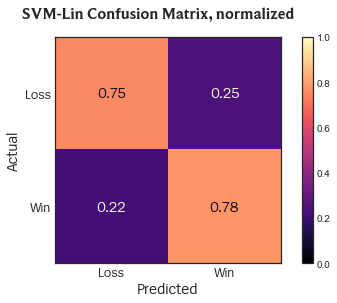

,Pred L,Pred W
True L,126,41
True W,36,127


In [131]:
# Confusion Matrix for SVM Linear, tuned model

# Compute confusion matrix
cnf_matrix_svm_lin = confusion_matrix(target_test, target_predicted_svm_lin)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_svm_lin, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('SVM-Lin Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_svm_lin)

##### SVM RBF (Radial Basis Function)

In [132]:
# SVM RBF, base model
from sklearn.svm import SVC
start_time = time.time()

# Define
svm_rbf = SVC(kernel = 'rbf', 
              random_state = 7)

# Fit
svm_rbf.fit(features_train_scaled, target_train)

# Predict
target_predicted_svm_rbf = svm_rbf.predict(features_test_scaled)

# Evaluate
running_time()
model_results_default(svm_rbf, target_predicted_svm_rbf, 'SVM-RBF')

Running time: 00:00:00

Default Parameters:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)

SVM-RBF Accuracy: 0.7515
SVM-RBF Lift: 0.2455

             precision    recall  f1-score   support

       Loss       0.76      0.75      0.75       167
        Win       0.75      0.75      0.75       163

avg / total       0.75      0.75      0.75       330



In [133]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(svm_rbf, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:01

Cross Validation Score for each K:
[ 0.7564  0.7949  0.7692  0.7949  0.7662
  0.7922  0.7368  0.7895  0.8158  0.7632]

Range: 0.0789

Average: 0.7779
Lift: 0.2718



Setting up a grid search for SVM RBF, according to the [documentation](http://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel):
> Proper choice of `C` and `gamma` is critical to the SVM’s performance. One is advised to use `sklearn.model_selection.GridSearchCV` with `C` and `gamma` spaced exponentially far apart to choose good values.

In [134]:
# Grid search for SVM RBF
start_time = time.time()

# Define the model to test
svm_rbf = SVC(kernel = 'rbf', 
              random_state = 7)

# Define range of parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Run grid search with 10-fold CV
grid_search = GridSearchCV(svm_rbf,  # <- Specify model to use
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           n_jobs = -1,  # Parallel processing. -1 to use all available cores
                           cv = 10)

grid_search.fit(features_train_scaled, target_train)

running_time()
print("Best Score: {0: .4f}".format(grid_search.best_score_))
print("Best Params: {}".format(grid_search.best_params_))

Running time: 00:00:54

Best Score:  0.8039
Best Params: {'C': 10, 'gamma': 0.01}


Now use those values to re-run the grid search on a narrower range.

In [135]:
# Refined Grid search for SVM RBF
start_time = time.time()

# Define the model to test
svm_rbf = SVC(kernel = 'rbf', 
              random_state = 7)

# Define range of parameters
param_grid = {
    'C': range(3, 25, 
               2),
    'gamma': np.arange(0.005, 0.075, 
                       0.005)
}

# Run grid search with 10-fold CV
grid_search = GridSearchCV(svm_rbf,  # <- Specify model to use
                           param_grid = param_grid, 
                           scoring = 'accuracy',
                           n_jobs = -1,  # Parallel processing. -1 to use all available cores
                           cv = 10)

grid_search.fit(features_train_scaled, target_train)

running_time()
print("Best Score: {0: .4f}".format(grid_search.best_score_))
print("Best Params: {}".format(grid_search.best_params_))

Running time: 00:01:34

Best Score:  0.8117
Best Params: {'C': 9, 'gamma': 0.02}


And now we can load those parameters into the model.

In [136]:
# SVM RBF, tuned model
start_time = time.time()

# Define
svm_rbf = SVC(kernel = 'rbf', 
              C = 9, 
              gamma = 0.02,
              random_state = 7)

# Fit
svm_rbf.fit(features_train_scaled, target_train)

# Predict
target_predicted_svm_rbf = svm_rbf.predict(features_test_scaled)

# Evaluate
running_time()
model_results(svm_rbf, target_predicted_svm_rbf, 'SVM-RBF')

Running time: 00:00:00

SVM-RBF Accuracy: 0.7758
SVM-RBF Lift: 0.2697

             precision    recall  f1-score   support

       Loss       0.78      0.77      0.78       167
        Win       0.77      0.78      0.77       163

avg / total       0.78      0.78      0.78       330



In [137]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(svm_rbf, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:01

Cross Validation Score for each K:
[ 0.7692  0.8462  0.8077  0.7692  0.8182
  0.8312  0.7895  0.8421  0.8289  0.8158]

Range: 0.0769

Average: 0.8118
Lift: 0.3057



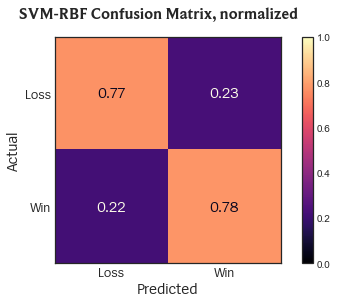

,Pred L,Pred W
True L,129,38
True W,36,127


In [138]:
# Confusion Matrix for SVM RBF, tuned model

# Compute confusion matrix
cnf_matrix_svm_rbf = confusion_matrix(target_test, target_predicted_svm_rbf)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_svm_rbf, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0) # Normalizes color scale to (0, 1) instead of (min, max) values
plt.suptitle('SVM-RBF Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# View absolute count matrix in a table
tidy(cnf_matrix_svm_rbf)

[Back to Models](#models)

<br>

#### Artificial Neural Network (ANN)
___
The heart of the ANN model class resides in "Hidden Layers"—magical black-boxes that transform input data beyond all human comprehension.

<center><i>Results in Brief</i></center>

|      **Model**       |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|----------------------|---------------|----------------------------------|-----------------------------|
| Default ANN, 1-layer |     75.73%    |<font color="green">+25.12%</font>|<font color="darkorange">14.98%</font>|
|   Tuned ANN, 1-layer |     80.78%    |<font color="green">+30.18%</font>|<font color="yellowgreen">9.62%</font>|
|   Tuned ANN, 2-layer |     80.79%    |<font color="green">+30.18%</font>|<font color="darkorange">11.36%</font>|

In [139]:
# Neural Network, base model
from sklearn.neural_network import MLPClassifier
start_time = time.time()

# Define
clf_ann = MLPClassifier(random_state = 7)

# Fit
clf_ann.fit(features_train_scaled, target_train)

# Predict
target_predicted_ann = clf_ann.predict(features_test_scaled)

# Evaluate
running_time()
model_results_default(clf_ann, target_predicted_ann, 'ANN')

Running time: 00:00:01

Default Parameters:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

ANN Accuracy: 0.7485
ANN Lift: 0.2424

             precision    recall  f1-score   support

       Loss       0.74      0.78      0.76       167
        Win       0.76      0.71      0.74       163

avg / total       0.75      0.75      0.75       330



In [140]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_ann, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:14

Cross Validation Score for each K:
[ 0.7436  0.7692  0.7821  0.6923  0.7532
  0.7273  0.7105  0.8421  0.7500  0.8026]

Range: 0.1498

Average: 0.7573
Lift: 0.2512



##### One Hidden Layer

In [141]:
# Neural Network, tuned model (one layer)
start_time = time.time()

# Define
clf_ann_1 = MLPClassifier(solver = 'lbfgs', 
                          alpha = 10, 
                          hidden_layer_sizes = (72), 
                          random_state = 7)

# Fit
clf_ann_1.fit(features_train_scaled, target_train)

# Predict
target_predicted_ann_1 = clf_ann_1.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_ann_1, target_predicted_ann_1, 'ANN-1')

Running time: 00:00:00

ANN-1 Accuracy: 0.7727
ANN-1 Lift: 0.2667

             precision    recall  f1-score   support

       Loss       0.77      0.78      0.78       167
        Win       0.78      0.76      0.77       163

avg / total       0.77      0.77      0.77       330



In [142]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_ann_1, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:07

Cross Validation Score for each K:
[ 0.7692  0.8462  0.8205  0.7821  0.8052
  0.8182  0.7500  0.8421  0.8026  0.8421]

Range: 0.0962

Average: 0.8078
Lift: 0.3018



##### Two Hidden Layers

The general "rule" for hidden layer sizes is that each layer should have fewer nodes than its input, but more than its output. Input can be either the features themselves or a previous hidden layer. Output can be either another downstream hidden layer, or the final classification outcomes. (Generally, one Hidden Layer is sufficient. Any more than two is considered excessive in most cases.)

So in the code below, we've settled on:

**293** data fratures <br>
\/ <br>
**168** nodes in HL1 <br>
\/ <br>
**18** nodes in HL2 <br>
\/ <br>
**2** final outcomes

In [143]:
# Neural Network, tuned model (two layers)
start_time = time.time()

# Define
clf_ann_2 = MLPClassifier(solver = 'lbfgs', 
                          alpha = 15, 
                          hidden_layer_sizes = (168, 18),
                          random_state = 7)

# Fit
clf_ann_2.fit(features_train_scaled, target_train)

# Predict
target_predicted_ann_2 = clf_ann_2.predict(features_test_scaled)

# Evaluate
running_time()
model_results(clf_ann_2, target_predicted_ann_2, 'ANN-2')

Running time: 00:00:02

ANN-2 Accuracy: 0.7788
ANN-2 Lift: 0.2727

             precision    recall  f1-score   support

       Loss       0.77      0.80      0.79       167
        Win       0.79      0.75      0.77       163

avg / total       0.78      0.78      0.78       330



In [144]:
# Verify with 10-fold Cross-validation
start_time = time.time()

scores = cross_val_score(clf_ann_2, features_train_scaled, target_train, cv = 10)

np.set_printoptions(formatter = {'float': '{: 0.4f}'.format}, linewidth = 45)

running_time()
print(cv_results(scores))

Running time: 00:00:20

Cross Validation Score for each K:
[ 0.7436  0.8333  0.7949  0.7821  0.8571
  0.8312  0.7500  0.8553  0.7895  0.8421]

Range: 0.1136

Average: 0.8079
Lift: 0.3018



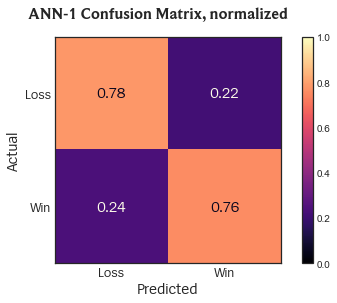

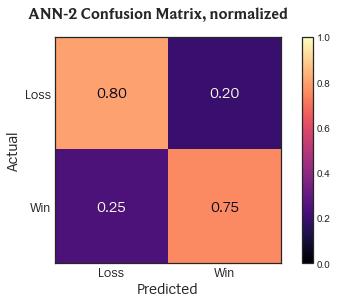

In [145]:
# Confusion Matrix for Neural Network, tuned models 1 & 2

# Compute confusion matrices
cnf_matrix_ann_1 = confusion_matrix(target_test, target_predicted_ann_1)  # <- Specify model to use
cnf_matrix_ann_2 = confusion_matrix(target_test, target_predicted_ann_2)  # <- Specify model to use
np.set_printoptions(precision = 2)

# Plot normalized confusion matrix, ANN-1
plt.figure()
plot_confusion_matrix(cnf_matrix_ann_1, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0)
plt.suptitle('ANN-1 Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

# Plot normalized confusion matrix, ANN-2
plt.figure()
plot_confusion_matrix(cnf_matrix_ann_2, classes = target_names, normalize = True, title = '\n')
plt.clim(0, 1.0)
plt.suptitle('ANN-2 Confusion Matrix, normalized', fontproperties = main, fontsize = 16)
plt.show()

In [146]:
# View absolute count matrix in a table
print("ANN-1, absolute counts")
tidy(cnf_matrix_ann_1)

ANN-1, absolute counts


,Pred L,Pred W
True L,131,36
True W,39,124


In [147]:
# View absolute count matrix in a table
print("ANN-2, absolute counts")
tidy(cnf_matrix_ann_2)

ANN-2, absolute counts


,Pred L,Pred W
True L,134,33
True W,40,123


[Back to Models](#models)

<br>

### Results & Conclusion
___

<center><b>Model Performance Comparison</b></center>
<center><i>Best Results from Each Section</i></center>

|                   **Model**                 |**CV Accuracy**|             **Lift**             |        **CV Spread**        |
|---------------------------------------------|---------------|----------------------------------|-----------------------------|
|<div title="Decision Tree">DT</div>          |69.36%|<font color="green">+18.75%</font>|<font color="darkorange">12.66%</font>|
|<div title="Extra Trees">XT</div>            |79.73%|<font color="green">+29.13%</font>|<font color="darkorange">11.84%</font>|
|<div title="Random Forest">RF</div>          |81.82%|<font color="green">+31.21%</font>|<font color="yellowgreen">9.27%</font>|
|<div title="Boosted Decision Tree">BDT</div> |78.19%|<font color="green">+27.59%</font>|<font color="darkorange">12.82%</font>|
|<div title="Gradient Boosting">GB</div>      |81.05%|<font color="green">+30.44%</font>|<font color="yellowgreen">7.59%</font>|
|<div title="Bagging">BAG</div>               |80.78%|<font color="green">+30.18%</font>|<font color="yellowgreen">8.27%</font>|
|<div title="Logistic Regression, L2 regularized">LOG (L2)</div>|80.13%|<font color="green">+29.53%</font>|<font color="yellowgreen">8.97%</font>|
|<div title="Logistic Regression, L1 regularized">LOG (L1)</div>|80.66%|<font color="green">+30.05%</font>|<font color="yellowgreen">7.29%</font>|
|<div title="Naïve Bayes, Bernoulli">NB-B</div>|74.27%|<font color="green">+23.66%</font>|<font color="yellowgreen">8.47%</font>|
|<div title="15-Nearest Neighbors">KNN-15</div>|73.51%|<font color="green">+22.91%</font>|<font color="yellowgreen">7.09%</font>|
|<div title="36-Nearest Neighbors">KNN-36</div>|75.98%|<font color="green">+25.37%</font>|<font color="darkorange">10.53%</font>|
|<div title="5-model Ensemble Stack (RF, GB, BAG, NB-B, LOG-L2)">STK-5</div>|82.08%|<font color="green">+31.47%</font>|<font color="yellowgreen">8.92%</font>|
|<div title="Support Vector Machine, Linear">SVM (Lin)</div>|80.79%|<font color="green">+30.19%</font>|<font color="yellowgreen">9.89%</font>|
|<div title="Support Vector Machine, RBF kernel">SVM (RBF)</div>|81.18%|<font color="green">+30.57%</font>|<font color="yellowgreen">7.69%</font>|
|<div title="Artificial Neural Network, 1 Hidden Layer">ANN-1</div>|80.78%|<font color="green">+30.18%</font>|<font color="yellowgreen">9.62%</font>|

Based on the results, the best models appear to be RF (Random Forest) and STK-5 (Stack Ensemble). The Stack model incorporates five of the above models, including the random forest.

Despite the STK model's slightly higher score, it comes with a massive increase in running time. The **random forest**, therefore, gets my recommendation for "best" model.

We should note, however, the unusual similarities in performance across models. Regardless of the model, optimal performance was always very similar, with nearly-identical result patterns (confusion matrices). Another concern is the constant issue with overfitting. No model, when tested with 10-fold cross-validation, resulted in a spread of less than 7 points in accuracy scores. 

These two issues combined—a plateau in accuracy scores and an unavoidable risk of overfitting—have led me to conclude that we simply need more data. 

Of course, a single person couldn't play enough matches in a lifetime to generate the amount of data we need. But if the scope of the question is expanded—from "what causes **me** to win?" to "what causes **anyone** to win?"—we just might be able to get even better answers.

##### Looking Forward

Scaling up this project presents interesting challenges. How many rows of data do we want? 10,000? 100,000? Running these kinds of models on that much data would likely require the use of a distributed computing service, likely Apache Spark. Constraints to scaling include the cost of that service, as well as the time required to make the API calls necessary to gather the data.

Beyond scaling, a further possibility is implementation, i.e. turning the knowledge gained into something useful. [Websites already exist](http://www.metasrc.com/na/aram/current?ranks=all) which are dedicated to aggregating match data to provide recommendations to users, but the use of predictive modeling could add new insight to such operations. Another possibility could make use of conditional probability to update in real-time the likelihood of a team winning their match, as new information becomes available.

___
<center><i>— End of Notebook —</i></center>
___

[Respawn at Base](#top)